# Data-Science-Challenge 2021: 
# Interpretierbares Maschinelles Lernen / Interpretable Machine Learning

In this analysis we focus on a more technical aspect of interpretable machine learning, i.e., on a quite powerful method for explaining arbitrary ML models. Our case study addresses the detection of insurance fraud.
We will build several prediction models for detecting insurance fraud: interpretable and a priori non-interpretable ones. To make a priori non-interpretable models explainable, in our case to explain their results to the fraud analyst, we generate separate explainers with a method called LIME (local interpretable model-agnostic explanations). Interpretable models (or at least explanations for their decisions) in the context of fraud detection are important to increase their acceptance and that the analyst really thinks them to be helpful. If the analyst is not sure about the model results and has the feeling of being confronted with a black box model without explanations, the model isn't likely to be used although it may save time and cost.<br><br>
As data set we use a kaggle data set with automobile insurance claims containing a flag for fraud, which was also used in last year's Data Science Challenge. The data is from https://www.kaggle.com/buntyshah/auto-insurance-claims-data (accessed 2021-06-21).

## 1. Prerequisites

As prerequisites we will set jupyter options as well as install (if necessary) and load all required packages.
The installation instructions are commented and need to be uncommented when they are to be executed.

In [2]:
# This option refers to jupyter and sets the number of displayed columns and rows
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [3]:
# Install required packages not already available in jupyter
#install.packages("skimr")
#install.packages("GGally")
#install.packages("e1071")
#install.packages("ranger")
#install.packages("h2o")
#install.packages("lime")

In [4]:
# Load required packages
library(skimr)
library(tidyverse)
library(ggplot2)
library(GGally)
library(lubridate)
library(caret)
library(e1071)
library(ranger)
library(h2o)
# When initializing h2o, a suitable 64-bit Java version is required
h2o.init()
library(lime)

Warning message:
"package 'skimr' was built under R version 3.6.3"Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.5     v purrr   0.3.2
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: lattice

Attaching package: 'caret'

The following obje


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\MICHAE~1\AppData\Local\Temp\RtmpSAtNVU\file27bc722528ad/h2o_Michaela_Baumann_started_from_r.out
    C:\Users\MICHAE~1\AppData\Local\Temp\RtmpSAtNVU\file27bc2bee1995/h2o_Michaela_Baumann_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 632 milliseconds 
    H2O cluster timezone:       Europe/Berlin 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.3 
    H2O cluster version age:    3 months and 7 days  
    H2O cluster name:           H2O_started_from_R_Michaela_Baumann_iny491 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.98 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
 

Warning message:
"package 'lime' was built under R version 3.6.3"
Attaching package: 'lime'

The following object is masked from 'package:dplyr':

    explain



## 2. The Data

We load and inspect the data consisting of 1000 automobile insurance claims. Putting the csv data file into the same path as the jupyter notebook should be enough to successfully load the data.

In [5]:
# Load data set
df <- read.table("insurance_claims.csv",sep=",",dec=".",header = T)

To get a first impression of the data we have a look at the first resp. last ten entries of the data set.

In [6]:
# Inspect some data rows
head(df,n = 10) # first ten entries
tail(df,n = 10) # last ten entries

months_as_customer age policy_number policy_bind_date policy_state
1  328                48  521585        2014-10-17       OH          
2  228                42  342868        2006-06-27       IN          
3  134                29  687698        2000-09-06       OH          
4  256                41  227811        1990-05-25       IL          
5  228                44  367455        2014-06-06       IL          
6  256                39  104594        2006-10-12       OH          
7  137                34  413978        2000-06-04       IN          
8  165                37  429027        1990-02-03       IL          
9   27                33  485665        1997-02-05       IL          
10 212                42  636550        2011-07-25       IL          
   policy_csl policy_deductable policy_annual_premium umbrella_limit
1  250/500    1000              1406.91                     0       
2  250/500    2000              1197.22               5000000       
3  100/300    2000              1413.14               5000000       
4  250/500    2000              1415.74               6000000       
5  500/1000   1000              1583.91               6000000       
6  250/500    1000              1351.10                     0       
7  250/500    1000              1333.35                     0       
8  100/300    1000              1137.03                     0       
9  100/300     500              1442.99                     0       
10 100/300     500              1315.68                     0       
   insured_zip insured_sex insured_education_level insured_occupation
1  466132      MALE        MD                      craft-repair      
2  468176      MALE        MD                      machine-op-inspct 
3  430632      FEMALE      PhD                     sales             
4  608117      FEMALE      PhD                     armed-forces      
5  610706      MALE        Associate               sales             
6  478456      FEMALE      PhD                     tech-support      
7  441716      MALE        PhD                     prof-specialty    
8  603195      MALE        Associate               tech-support      
9  601734      FEMALE      PhD                     other-service     
10 600983      MALE        PhD                     priv-house-serv   
   insured_hobbies insured_relationship capital.gains capital.loss
1  sleeping        husband              53300              0      
2  reading         other-relative           0              0      
3  board-games     own-child            35100              0      
4  board-games     unmarried            48900         -62400      
5  board-games     unmarried            66000         -46000      
6  bungie-jumping  unmarried                0              0      
7  board-games     husband                  0         -77000      
8  base-jumping    unmarried                0              0      
9  golf            own-child                0              0      
10 camping         wife                     0         -39300      
   incident_date incident_type            collision_type  incident_severity
1  2015-01-25    Single Vehicle Collision Side Collision  Major Damage     
2  2015-01-21    Vehicle Theft            ?               Minor Damage     
3  2015-02-22    Multi-vehicle Collision  Rear Collision  Minor Damage     
4  2015-01-10    Single Vehicle Collision Front Collision Major Damage     
5  2015-02-17    Vehicle Theft            ?               Minor Damage     
6  2015-01-02    Multi-vehicle Collision  Rear Collision  Major Damage     
7  2015-01-13    Multi-vehicle Collision  Front Collision Minor Damage     
8  2015-02-27    Multi-vehicle Collision  Front Collision Total Loss       
9  2015-01-30    Single Vehicle Collision Front Collision Total Loss       
10 2015-01-05    Single Vehicle Collision Rear Collision  Total Loss       
   authorities_contacted incident_state incident_city incident_location 
1  Police                SC             Columbus      9935

months_as_customer age policy_number policy_bind_date policy_state
991  286                43  663190        1994-02-05       IL          
992  257                44  109392        2006-07-12       OH          
993   94                26  215278        2007-10-24       IN          
994  124                28  674570        2001-12-08       OH          
995  141                30  681486        2007-03-24       IN          
996    3                38  941851        1991-07-16       OH          
997  285                41  186934        2014-01-05       IL          
998  130                34  918516        2003-02-17       OH          
999  458                62  533940        2011-11-18       IL          
1000 456                60  556080        1996-11-11       OH          
     policy_csl policy_deductable policy_annual_premium umbrella_limit
991  100/300     500              1564.43               3000000       
992  100/300    1000              1280.88                     0       
993  100/300     500               722.66                     0       
994  250/500    1000              1235.14                     0       
995  500/1000   1000              1347.04                     0       
996  500/1000   1000              1310.80                     0       
997  100/300    1000              1436.79                     0       
998  250/500     500              1383.49               3000000       
999  500/1000   2000              1356.92               5000000       
1000 250/500    1000               766.19                     0       
     insured_zip insured_sex insured_education_level insured_occupation
991  477644      FEMALE      MD                      prof-specialty    
992  433981      MALE        MD                      other-service     
993  433696      MALE        MD                      exec-managerial   
994  443567      MALE        MD                      exec-managerial   
995  430665      MALE        High School             sales             
996  431289      FEMALE      Masters                 craft-repair      
997  608177      FEMALE      PhD                     prof-specialty    
998  442797      FEMALE      Masters                 armed-forces      
999  441714      MALE        Associate               handlers-cleaners 
1000 612260      FEMALE      Associate               sales             
     insured_hobbies insured_relationship capital.gains capital.loss
991  movies          unmarried            77500         -32800      
992  basketball      other-relative       59400         -32200      
993  camping         husband              50300              0      
994  camping         husband                  0         -32100      
995  bungie-jumping  own-child                0         -82100      
996  paintball       unmarried                0              0      
997  sleeping        wife                 70900              0      
998  bungie-jumping  other-relative       35100              0      
999  base-jumping    wife                     0              0      
1000 kayaking        husband                  0              0      
     incident_date incident_type            collision_type  incident_severity
991  2015-01-31    Single Vehicle Collision Rear Collision  Minor Damage     
992  2015-02-06    Single Vehicle Collision Rear Collision  Total Loss       
993  2015-01-23    Multi-vehicle Collision  Front Collision Major Damage     
994  2015-02-17    Multi-vehicle Collision  Side Collision  Total Loss       
995  2015-01-22    Parked Car               ?               Minor Damage     
996  2015-02-22    Single Vehicle Collision Front Collision Minor Damage     
997  2015-01-24    Single Vehicle Collision Rear Collision  Major Damage     
998  2015-01-23    Multi-vehicle Collision  Side Collision  Minor Damage     
999  2015-02-26    Single Vehicle Collision Rear Collision  Major Damage     
1000 2015-02-26    Parked Car               ?               Minor Damage     
     authorities_contac

When inspecting the entries we can see how dates are formatted: YYYY-MM-DD. There is also a column with zip-codes ("insured_zip"), however, as there aren't any explanations to the data set, it is not clear whether there is a structure within these codes (like a hierarchical clustering). There seem to be missing or unknown values in the columns "collision_type", "property_damage" or "police_report_available" which are marked with a "?". The last column "X_c39" (which originally has the name "\_c39" but was renamed automatically) seems to have a lot of NAs.

In [7]:
# Get a summary that clearly distiguishes between factor, numeric and logical variables
skim(df)

-- Data Summary ------------------------
                           Values
Name                       df    
Number of rows             1000  
Number of columns          40    
_______________________          
Column type frequency:           
  factor                   21    
  logical                  1     
  numeric                  18    
________________________         
Group variables            None  

-- Variable type: factor -------------------------------------------------------
# A tibble: 21 x 6
   skim_variable           n_missing complete_rate ordered n_unique
 * <chr>                       <int>         <dbl> <lgl>      <int>
 1 policy_bind_date                0             1 FALSE        951
 2 policy_state                    0             1 FALSE          3
 3 policy_csl                      0             1 FALSE          3
 4 insured_sex                     0             1 FALSE          2
 5 insured_education_level         0             1 FALSE          7
 6 insur

There are, when reading the data without further specifications, 21 factor variables (including the target fraud_reported) and 18 numeric variables. Column X_c39 (the only logical variable) seems to be empty. Other columns are not marked as missing, however, as we already found question marks in some of the entries, missing values seem to be coded.<br>

However, some of the variables are wrongly classified. These variables are in fact not numeric but factor variables: policy_number, insured_zip. The auto_year could also be seen as a factor, as you cannot really calculate with the years (like averaging etc.). The same holds for incident_hour_of_the_day. Furthermore, the auto_year (probably the fabrication or first approval date of the claimant's vehicle) is not meaningful as it is, but we can derive, e.g., the approximate age of the car at incident time.<br>

We reset the types of the variables from numeric to factor.

In [8]:
# Factorize features
df[,"policy_number"] <- as.factor(df[,"policy_number"])
df[,"insured_zip"] <- as.factor(df[,"insured_zip"])
df[,"auto_year"] <- as.factor(df[,"auto_year"])
df[,"incident_hour_of_the_day"] <- as.factor(df[,"incident_hour_of_the_day"])

In [9]:
# Get a new summary that clearly distiguishes between factor, numeric and logical variables
skim(df)

-- Data Summary ------------------------
                           Values
Name                       df    
Number of rows             1000  
Number of columns          40    
_______________________          
Column type frequency:           
  factor                   25    
  logical                  1     
  numeric                  14    
________________________         
Group variables            None  

-- Variable type: factor -------------------------------------------------------
# A tibble: 25 x 6
   skim_variable            n_missing complete_rate ordered n_unique
 * <chr>                        <int>         <dbl> <lgl>      <int>
 1 policy_number                    0             1 FALSE       1000
 2 policy_bind_date                 0             1 FALSE        951
 3 policy_state                     0             1 FALSE          3
 4 policy_csl                       0             1 FALSE          3
 5 insured_zip                      0             1 FALSE        995
 

Now, there are 25 factor variables (including the target fraud_reported) and 14 numeric variables.

Regarding the number of factors for the factor variables we see huge differences ranging from 2 to 1000. The policy_number has 1000 different levels which means in this case, that there is no policy with more than one claim in our data set. The incident location has also 1000 different values, but as we see above, these locations are written addresses. Fraud reported has 2 different values and no missing ones, so we can assume that all entries are labeled correctly. In contrast to 951 policy bind dates there are only 60 different incident dates.<br>

The "csl" in the columns "policy\_csl" most probably stands for "combined single limit". Investopedia (https://www.investopedia.com/terms/c/combined-single-limits.asp#:~:text=Combined%20single%20limits%20are%20a,property%20damage%20in%20an%20incident, accessed 2021-06-22) defines this as follows: _"Combined single limits are a provision of an insurance policy that limits the coverage for all components of a claim to a single dollar amount. A combined single limit policy has a maximum dollar amount that covers any combination of injuries or property damage in an incident."_ <br>

The variable bodily_injuries seems to be the number of injuries (or injured persons) as it starts with 0 and not a code for certain injury types.

The share of fraudulent cases is 24.7 % (247 of 1000 rows) which is quite a high number compared to real-world data sets. Thus, one may suspect that this data set is an artificial one. For the remainder of this analysis, we do not want to focus on this aspect since we are interested in the explainability of machine learning algorithms and not so much on data plausibility. We just take this data set as an exemplary data set.

## 3. Explorative Data Analysis

Next, we inspect the factor and numeric variables separately especially with respect to the target variable fraud_reported. For this, we divide the original data set into two data sets with only numeric or factor variables, respectively.

In [10]:
# Create data sets with numeric resp. factor variables only
num <- unlist(lapply(df, is.numeric))  
df_num <- df[,num]

fac <- unlist(lapply(df, is.factor))  
df_fac <- df[,fac]

In [11]:
head(df_num)
head(df_fac)

# for verification of the split
sprintf("number of numeric columns: %i", ncol(df_num))
sprintf("number of factor columns: %i", ncol(df_fac))

months_as_customer age policy_deductable policy_annual_premium umbrella_limit
1 328                48  1000              1406.91                     0       
2 228                42  2000              1197.22               5000000       
3 134                29  2000              1413.14               5000000       
4 256                41  2000              1415.74               6000000       
5 228                44  1000              1583.91               6000000       
6 256                39  1000              1351.10                     0       
  capital.gains capital.loss number_of_vehicles_involved bodily_injuries
1 53300              0       1                           1              
2     0              0       1                           0              
3 35100              0       3                           2              
4 48900         -62400       1                           1              
5 66000         -46000       1                           0              
6     0              0       3                           0              
  witnesses total_claim_amount injury_claim property_claim vehicle_claim
1 2         71610              6510         13020          52080        
2 0          5070               780           780           3510        
3 3         34650              7700          3850          23100        
4 2         63400              6340          6340          50720        
5 1          6500              1300           650           4550        
6 2         64100              6410          6410          51280

policy_number policy_bind_date policy_state policy_csl insured_zip
1 521585        2014-10-17       OH           250/500    466132     
2 342868        2006-06-27       IN           250/500    468176     
3 687698        2000-09-06       OH           100/300    430632     
4 227811        1990-05-25       IL           250/500    608117     
5 367455        2014-06-06       IL           500/1000   610706     
6 104594        2006-10-12       OH           250/500    478456     
  insured_sex insured_education_level insured_occupation insured_hobbies
1 MALE        MD                      craft-repair       sleeping       
2 MALE        MD                      machine-op-inspct  reading        
3 FEMALE      PhD                     sales              board-games    
4 FEMALE      PhD                     armed-forces       board-games    
5 MALE        Associate               sales              board-games    
6 FEMALE      PhD                     tech-support       bungie-jumping 
  insured_relationship incident_date incident_type            collision_type 
1 husband              2015-01-25    Single Vehicle Collision Side Collision 
2 other-relative       2015-01-21    Vehicle Theft            ?              
3 own-child            2015-02-22    Multi-vehicle Collision  Rear Collision 
4 unmarried            2015-01-10    Single Vehicle Collision Front Collision
5 unmarried            2015-02-17    Vehicle Theft            ?              
6 unmarried            2015-01-02    Multi-vehicle Collision  Rear Collision 
  incident_severity authorities_contacted incident_state incident_city
1 Major Damage      Police                SC             Columbus     
2 Minor Damage      Police                VA             Riverwood    
3 Minor Damage      Police                NY             Columbus     
4 Major Damage      Police                OH             Arlington    
5 Minor Damage      None                  NY             Arlington    
6 Major Damage      Fire                  SC             Arlington    
  incident_location  incident_hour_of_the_day property_damage
1 9935 4th Drive     5                        YES            
2 6608 MLK Hwy       8                        ?              
3 7121 Francis Lane  7                        NO             
4 6956 Maple Drive   5                        ?              
5 3041 3rd Ave       20                       NO             
6 8973 Washington St 19                       NO             
  police_report_available auto_make auto_model auto_year fraud_reported
1 YES                     Saab      92x        2004      Y             
2 ?                       Mercedes  E400       2007      Y             
3 NO                      Dodge     RAM        2007      N             
4 NO                      Chevrolet Tahoe      2014      Y             
5 NO                      Accura    RSX        2009      N             
6 NO                      Saab      95         2003      Y

[1] "number of numeric columns: 14"

[1] "number of factor columns: 25"

### 3.1 Factor Variables

We inspect the levels of the factor variables to get a first impression of their values. 

In [12]:
sapply(df_fac,levels)

$policy_number
   [1] "100804" "101421" "104594" "106186" "106873" "107181" "108270" "108844"
   [9] "109392" "110084" "110122" "110143" "110408" "111874" "113464" "113516"
  [17] "114839" "115399" "116645" "116700" "116735" "117862" "118137" "118236"
  [25] "119513" "120485" "121439" "125324" "125591" "127313" "127754" "129872"
  [33] "130156" "130930" "131478" "132871" "132902" "133889" "134430" "135400"
  [41] "136520" "137675" "139484" "139872" "140880" "140977" "143038" "143109"
  [49] "143626" "143924" "143972" "144323" "146138" "148498" "149367" "149467"
  [57] "149601" "149839" "150181" "153027" "153154" "153298" "154280" "154982"
  [65] "155604" "155724" "155912" "156636" "156694" "159243" "159536" "159768"
  [73] "162004" "163161" "164464" "164988" "165485" "165565" "166264" "167231"
  [81] "167466" "168151" "168260" "171147" "171183" "171254" "172307" "174701"
  [89] "175177" "175553" "175960" "178081" "179538" "180008" "180286" "180720"
  [97] "182450" "182953" "183430" "184938" "185124" "186934" "187775" "190588"
 [105] "191891" "192524" "193213" "193442" "200152" "200827" "203250" "203914"
 [113] "204294" "205134" "206004" "206213" "206667" "208298" "209177" "211578"
 [121] "212580" "212674" "214618" "215278" "215534" "216738" "217899" "217938"
 [129] "218109" "218456" "218684" "219028" "221186" "221283" "221854" "223404"
 [137] "225865" "226330" "226725" "227244" "227811" "228403" "230223" "231127"
 [145] "231508" "231548" "232854" "235097" "235220" "235869" "237418" "238196"
 [153] "238412" "241562" "243226" "246435" "246705" "246882" "247116" "247505"
 [161] "247801" "248467" "249048" "250162" "250249" "250833" "253005" "253085"
 [169] "253791" "254837" "258265" "259792" "260845" "261119" "261315" "261905"
 [177] "263108" "263159" "264221" "265026" "265093" "265437" "266247" "267808"
 [185] "267885" "268833" "270208" "272330" "272910" "275092" "275265" "276804"
 [193] "277767" "278091" "279422" "280709" "281388" "282195" "283052" "283267"
 [201] "283414" "283925" "284143" "284834" "284836" "285496" "287436" "287489"
 [209] "288580" "290162" "290971" "291006" "291544" "291902" "293794" "296960"
 [217] "297816" "298412" "299796" "302669" "303987" "305758" "307195" "307447"
 [225] "307469" "309323" "311783" "312940" "315041" "315631" "319232" "320251"
 [233] "322609" "322613" "326180" "326289" "326322" "327488" "327856" "328387"
 [241] "330119" "330506" "330591" "331170" "331595" "331683" "332867" "332892"
 [249] "334749" "335780" "336047" "336614" "337158" "337677" "338070" "340614"
 [257] "342830" "342868" "343161" "343421" "344480" "345539" "346002" "346940"
 [265] "347984" "348209" "348814" "349658" "351741" "352120" "354105" "354455"
 [273] "354481" "355085" "356590" "356768" "357394" "357713" "357808" "357949"
 [281] "360770" "361829" "362407" "362843" "364055" "365364" "367455" "367595"
 [289] "368050" "369048" "369226" "369781" "369941" "371635" "372891" "372912"
 [297] "373600" "373731" "373935" "374545" "376879" "378587" "378588" "379268"
 [305] "379882" "380067" "382394" "384618" "385932" "386429" "386690" "388616"
 [313] "388671" "389238" "389525" "390256" "390381" "391003" "391652" "394975"
 [321] "395269" "395572" "395983" "396002" "396224" "396590" "398102" "398484"
 [329] "398683" "399524" "403737" "403776" "405533" "406567" "407958" "409074"
 [337] "411289" "411477" "412703" "413192" "413978" "414519" "414779" "414913"
 [345] "419510" "419954" "420810" "420815" "420948" "421092" "421940" "424358"
 [353] "424862" "425631" "425973" "426708" "427199" "427484" "428230" "429027"
 [361] "430029" "430794" "431283" "431478" "431583" "431876" "432068" "432740"
 [369] "433663" "434507" "435784" "436126" "437442" "437573" "437960" "438817"
 [377] "439049" "439341" "439660" "439828" "439844" "440616" "442494" "442677"
 [385] "442795" "444035" "444422" "445195" "445289" "445694" "445973" "447226"
 [393] "448642" "448961" "449263" "454086" "454758" "456604" "457188" "457244"
 [401] "458829" "461962" "463237" "

The incident dates suggest that the data set is constructed to contain only claims with incident dates between 2015-01-01 and 2015-03-01 which is why there are only such a few different incident dates compared to other date variables.<br> 

Further, there are only 7 incident cities for 7 incident states, which backs the assumption of an artificial data set. For example, the city Northbend does not seem to exist (artificial data set?). This is why we do not try to convert the addresses into GPS coordinates. Further, there are no living addresses given to calculate, e.g., distances between living and incident addresses.<br>

Missing or unknown values are marked with a ? in the columns collision_type, property_damage and police_report_available, as assumed before.<br>

The policy_number is not needed here as we have not more than one claim for a policy in our data set and we do not have any other tables for possible joins. As we cannot be sure about the structure (e.g., hierarchical) of the zip codes (insured_zip) and there are almost as many different zip codes as claims, it is not meaningful to use this feature. It is assumed that policy_state denotes the state where the insured lives (although this variable is not named insured_state). The incident_location is also not considered further (as stated above).<br>

Concerning the dates, we do not regard the dates as they are but compute time spans for further analyses. That is, with policy_bind_date and incident_date we derive a policy_bind_timespan (in weeks) and with auto_year and incident_date we derive an approximate auto_incident_years (in years). The incident_date we cluster according to the months.

In [13]:
# convert date columns to dates
pbd <- as.Date(df_fac[,"policy_bind_date"])
id <- as.Date(df_fac[,"incident_date"])
ay <- as.Date(sapply(df_fac[,"auto_year"],paste0,"-01-01")) 
# month and day is always set to 01 resp. 01 to not get negative values when differencing later

In [14]:
# calculate policy bind timespan as number of whole weeks (using lubridate)
policy_bind_weeks <- floor(interval(pbd, id) / dweeks(1))
# calculate auto incident years as number of whole years between auto_year and incident_date (approximate)
auto_incident_years <- floor(interval(ay,id) / dyears(1))
# get incident month as factor variable
incident_month <- as.factor(lubridate::month(id))

In [15]:
# select relevant factor variables and add new factor variables
df_fac_new <- df_fac %>% select(-c(policy_number,insured_zip,incident_location,policy_bind_date, incident_date, auto_year)) %>% 
mutate(incident_month)

In [16]:
# inspect the transformed data set
skim(df_fac_new)

-- Data Summary ------------------------
                           Values    
Name                       df_fac_new
Number of rows             1000      
Number of columns          20        
_______________________              
Column type frequency:               
  factor                   20        
________________________             
Group variables            None      

-- Variable type: factor -------------------------------------------------------
# A tibble: 20 x 6
   skim_variable            n_missing complete_rate ordered n_unique
 * <chr>                        <int>         <dbl> <lgl>      <int>
 1 policy_state                     0             1 FALSE          3
 2 policy_csl                       0             1 FALSE          3
 3 insured_sex                      0             1 FALSE          2
 4 insured_education_level          0             1 FALSE          7
 5 insured_occupation               0             1 FALSE         14
 6 insured_hobbies               

In order to visualize the dependencies between the target and every factor variable, we draw bar charts with a differentiation between fraud reported and fraud not reported. In the whole data set, the share of fraudulent cases is about a forth. From a univariate perspective, variables with divergent shares among the different factor values better differentiate between fraudulent and non-fraudulent cases. Further, factor levels with only a small number of cases are probably less reliable. However, such an impression is only univariate.

In [17]:
# Transform data set of factor variables to long format for visualization in ggplot (faceting)
# and aggregate/count the number of cases
# while keeping the variable fraud_reported as separate column
faccols <- colnames(df_fac_new %>% select(-c(fraud_reported)))
df_fac_new_long <- pivot_longer(df_fac_new, cols=all_of(faccols), names_to = "key",values_to="value") %>% 
    count(fraud_reported,key,value)

In [18]:
head(df_fac_new_long)

fraud_reported key                   value     n  
1 N              authorities_contacted Ambulance 139
2 N              authorities_contacted Fire      163
3 N              authorities_contacted None       85
4 N              authorities_contacted Other     135
5 N              authorities_contacted Police    231
6 N              auto_make             Accura     55

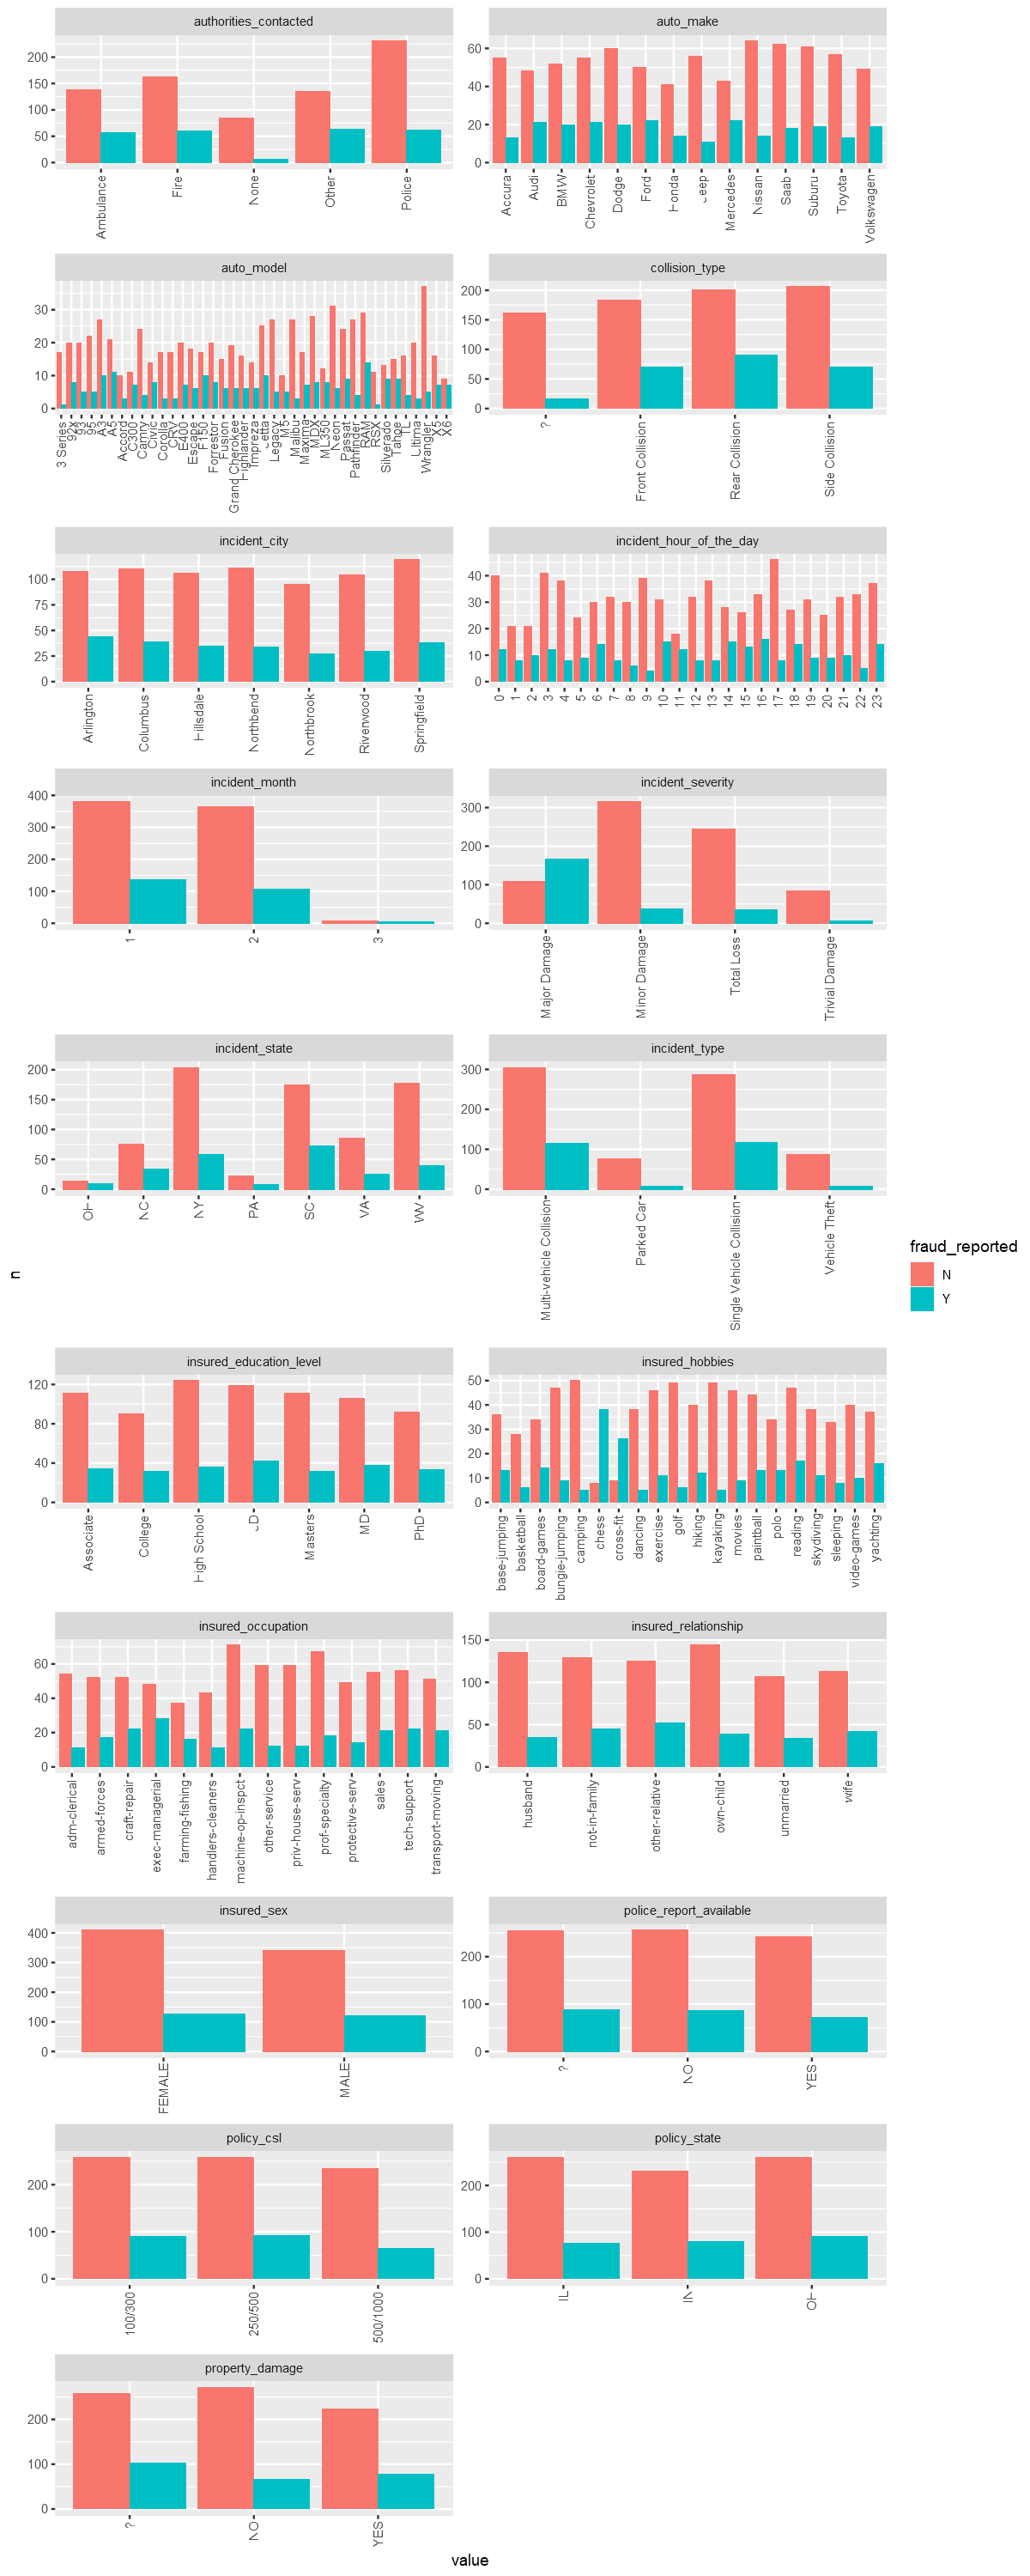

In [19]:
# Barplots with the absolute number of cases as height
options(repr.plot.width=10, repr.plot.height=25)
ggplot(df_fac_new_long, aes(fill=fraud_reported, x=value, y=n)) + 
    geom_bar(position="dodge", stat="identity") +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    facet_wrap(~key, ncol=2, scales = 'free')

From the chart with the absolute values, we see that there are not many cases with incident_month=3 in our data set (but this is expectable since the data is until 01-03). Cases with incident_state=OH and incident_state=PA are relatively few. As the cases with unknown or absent values marked with a question mark are not only a few, we keep the "?" and treat it as a separate factor of the respective variable.

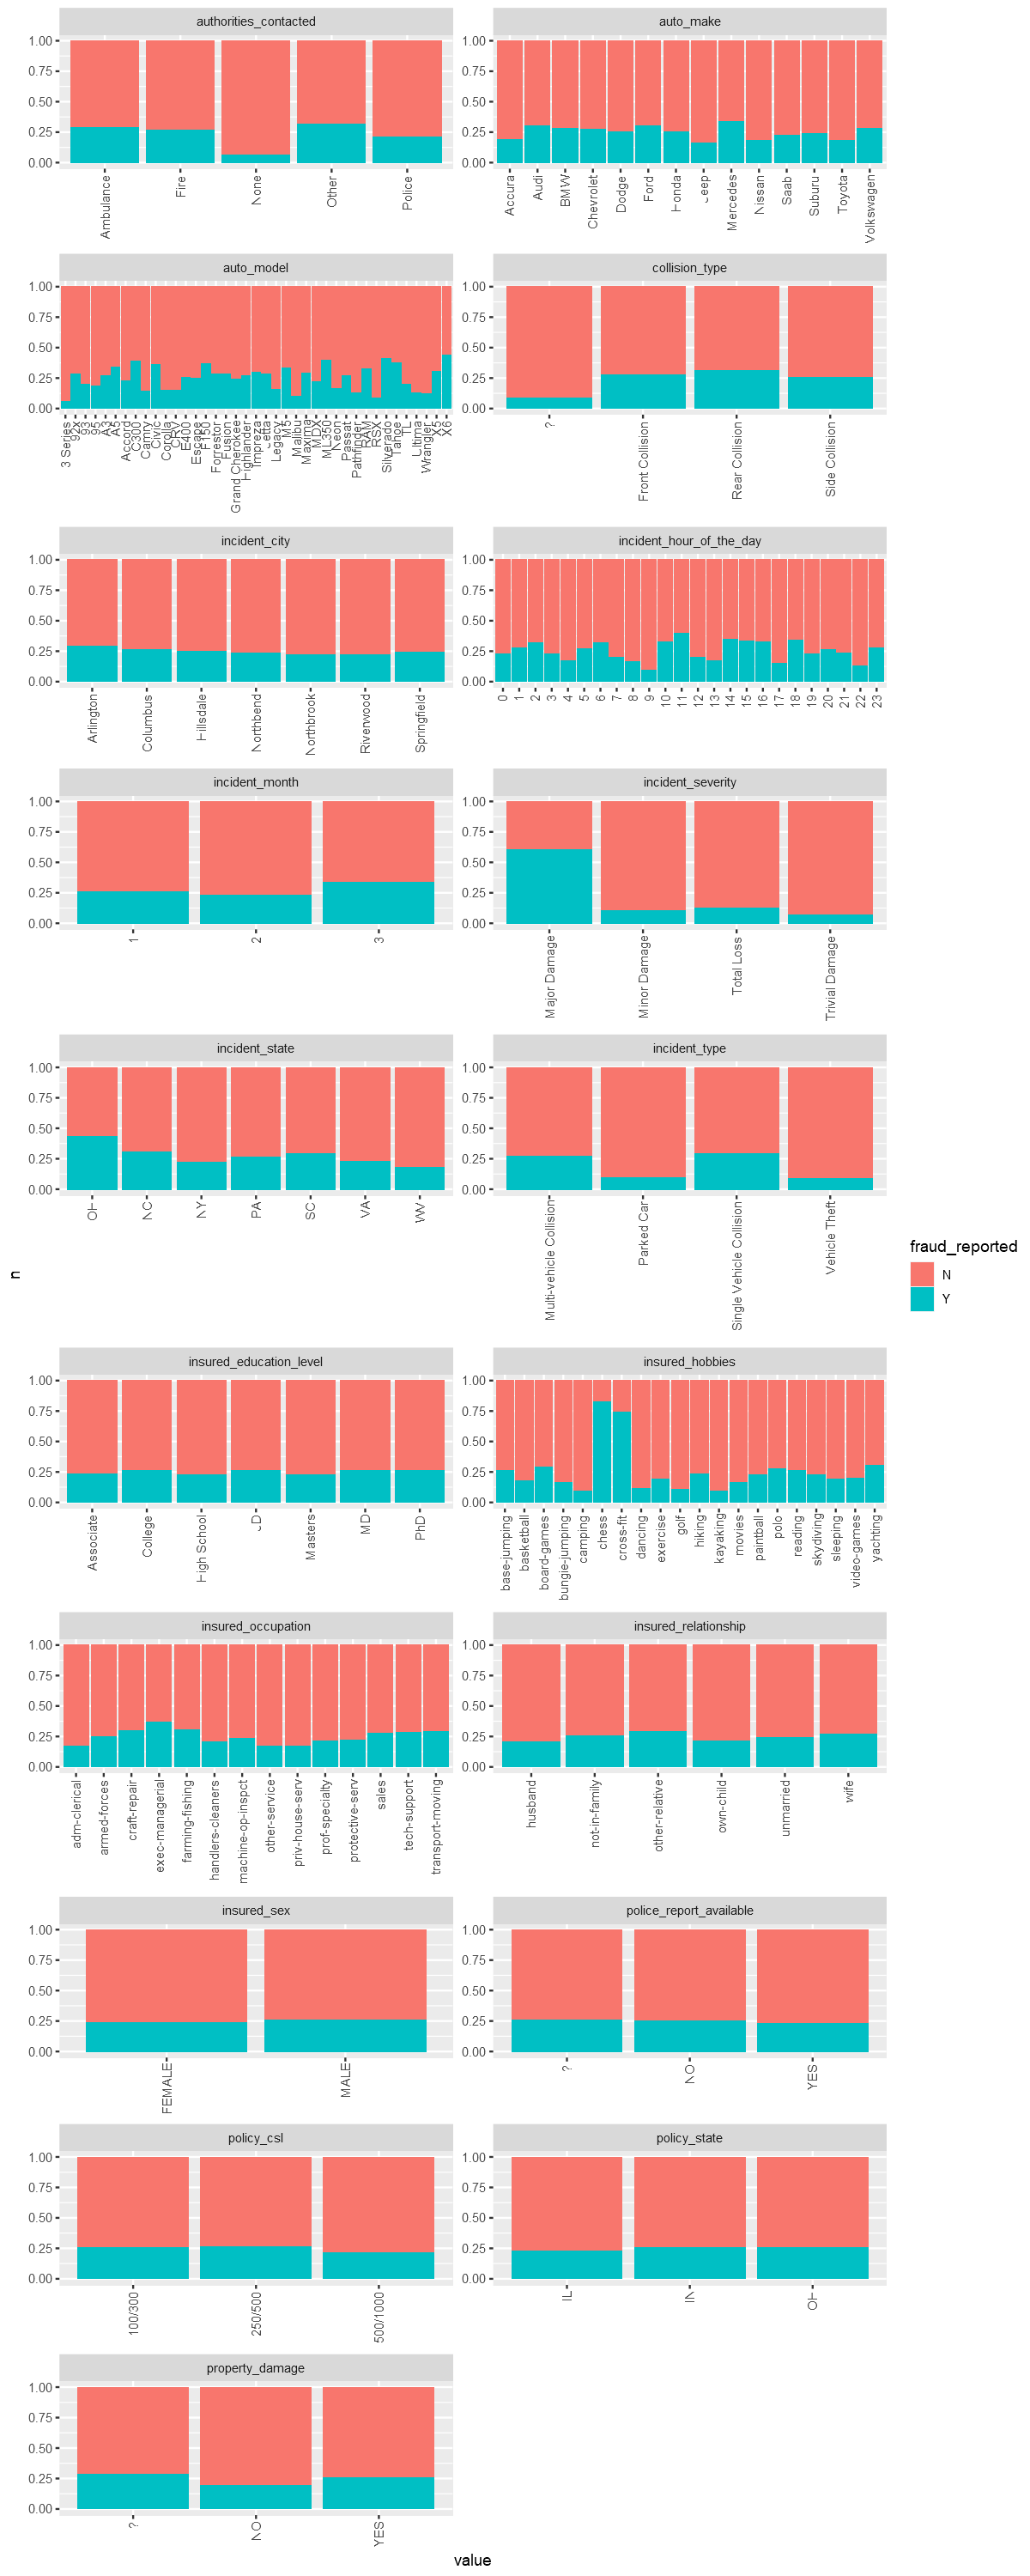

In [20]:
# Barplots with the height adjusted to 1 to better see the shares of the target variable's outcome
options(repr.plot.width=10, repr.plot.height=25)
ggplot(df_fac_new_long, aes(fill=fraud_reported, x=value, y=n)) + 
    geom_bar(position="fill", stat="identity") +
    scale_x_discrete(guide = guide_axis(angle = 90)) +
    facet_wrap(~key, ncol=2, scales = 'free')

In the plot with the adjusted bar height we see that there are variables that seem to have a stronger influence on the target variable than others, for example, the incident_severity, particularly the distinction between "Major Damage" and the other values. There are also two insured_hobbies for which the fraud appeared more often. In contrast, some variables do not seem to have a great influence (at least not considered univariately), e.g., the indicent_city and the policy_state or the policy_csl.

### 3.2 Numeric Variables

To get a first impression of the distribution of the numeric variables, including the derived ones policy_bind_weeks and auto_incident_years, we draw boxplots. In this way, we can find potentially outliers and see some of the most important distribution indicators. As a preparatory step, we transform the data set to be suitable in ggplot's plotting instructions (faceting), i.e., we transform the data set from wide to long format. Additionally, we add the target variable to be able to see differences of the numeric variables' distributions with respect to the target.

In [21]:
# Create vector of numeric column names as reference
numcols <- c(colnames(df_num),"policy_bind_weeks","auto_incident_years")
# Add target variable (although factor variable) to numeric data
df_num_target <- data.frame(df_num,policy_bind_weeks,auto_incident_years,fraud_reported=df[,"fraud_reported"])
# Create long format for use in ggplot instructions
df_num_long <- pivot_longer(df_num_target, cols=all_of(numcols), names_to = "key",values_to="value")

In [22]:
head(df_num_target)
head(df_num_long)

months_as_customer age policy_deductable policy_annual_premium umbrella_limit
1 328                48  1000              1406.91                     0       
2 228                42  2000              1197.22               5000000       
3 134                29  2000              1413.14               5000000       
4 256                41  2000              1415.74               6000000       
5 228                44  1000              1583.91               6000000       
6 256                39  1000              1351.10                     0       
  capital.gains capital.loss number_of_vehicles_involved bodily_injuries
1 53300              0       1                           1              
2     0              0       1                           0              
3 35100              0       3                           2              
4 48900         -62400       1                           1              
5 66000         -46000       1                           0              
6     0              0       3                           0              
  witnesses total_claim_amount injury_claim property_claim vehicle_claim
1 2         71610              6510         13020          52080        
2 0          5070               780           780           3510        
3 3         34650              7700          3850          23100        
4 2         63400              6340          6340          50720        
5 1          6500              1300           650           4550        
6 2         64100              6410          6410          51280        
  policy_bind_weeks auto_incident_years fraud_reported
1   14              11                  Y             
2  447               8                  Y             
3  754               8                  N             
4 1285               1                  Y             
5   36               6                  N             
6  429              12                  Y

fraud_reported key                   value   
1 Y              months_as_customer      328.00
2 Y              age                      48.00
3 Y              policy_deductable      1000.00
4 Y              policy_annual_premium  1406.91
5 Y              umbrella_limit            0.00
6 Y              capital.gains         53300.00

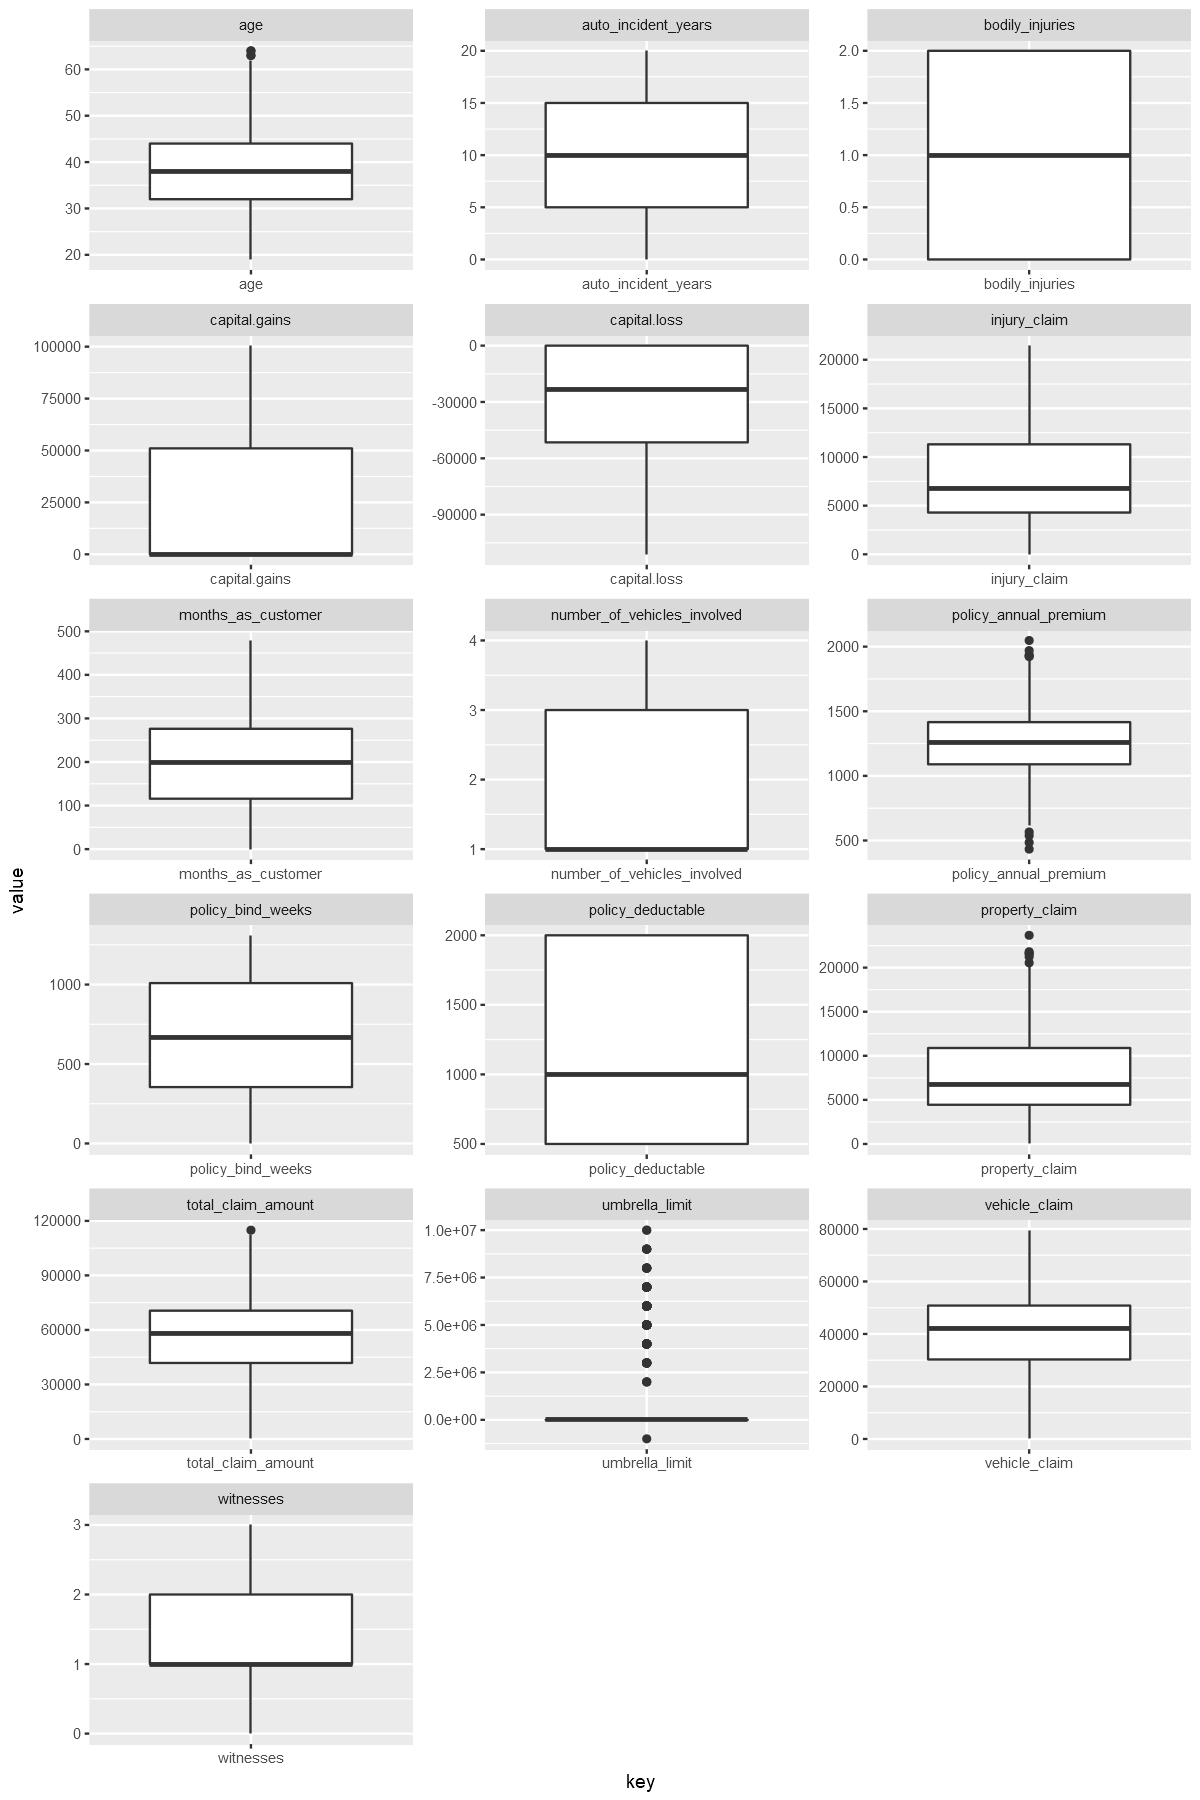

In [23]:
options(repr.plot.width=10, repr.plot.height=15)
ggplot(df_num_long, aes(x=key,y=value)) +
geom_boxplot() +
#coord_flip() +
facet_wrap(~key, ncol=3, scales = 'free')

At a first glance, the boxplots reveal no dramatic inconsistencies. To see the influence of the target variable, we draw histograms for each variable where we distinguish between the two outcomes of the target variable (fraud_reported = "Y" and fraud_reported = "N"). Note that some of the numeric variables are discrete (such as bodily_injuries or number_of_vehicles_involved) where the histogram only shows bars at the discrete values.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


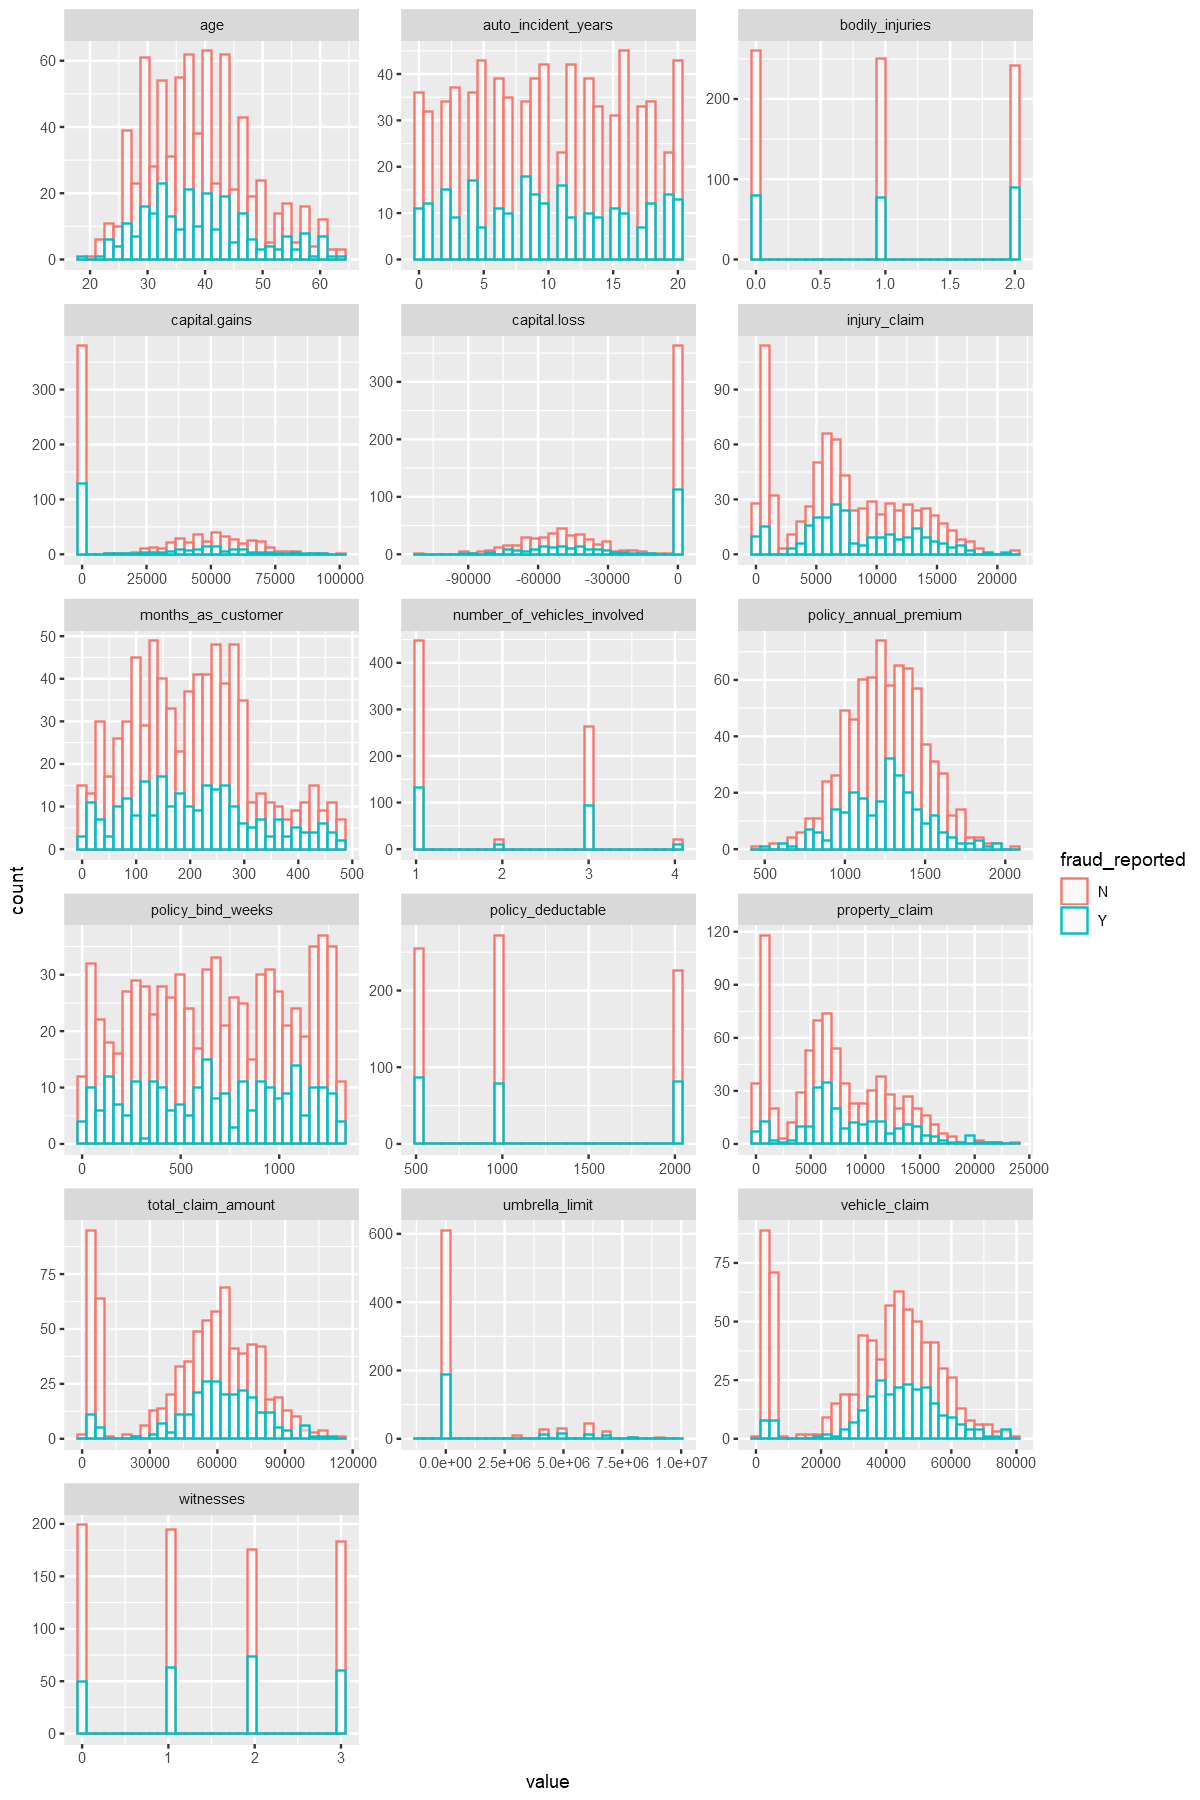

In [24]:
options(repr.plot.width=10, repr.plot.height=15)
ggplot(df_num_long, aes(x=value, color=fraud_reported)) +
geom_histogram(fill="white", alpha=0.5, position="identity") +
facet_wrap(~key, ncol=3, scales = 'free')

We see that the fraud rate is slightly higher for, e.g., quite new customers (months_as_customer) and for very young and very old customers. On contrast, it is comparatively low for claims with a low total_claim_amount. Over 600 of the 1000 cases have an umbrella_limit of/near 0. <br>

The meaning of capital.gains and capital.loss is not clear, especially since for some cases there are positive capital gains as well as negative capital losses (which supposedly should be positive losses or negative gains), as can be seen below. 

In [25]:
# capital.gains and capital.loss
head(df_num[,c("capital.gains","capital.loss")],20)

capital.gains capital.loss
1  53300              0      
2      0              0      
3  35100              0      
4  48900         -62400      
5  66000         -46000      
6      0              0      
7      0         -77000      
8      0              0      
9      0              0      
10     0         -39300      
11 38400              0      
12     0         -51000      
13     0              0      
14 52800         -32800      
15 41300         -55500      
16 55700              0      
17 63600              0      
18 53500              0      
19 45500         -37800      
20 57000         -27300

To see whether there are correlated (and therefore redundant) numeric columns, we draw a heatmap.

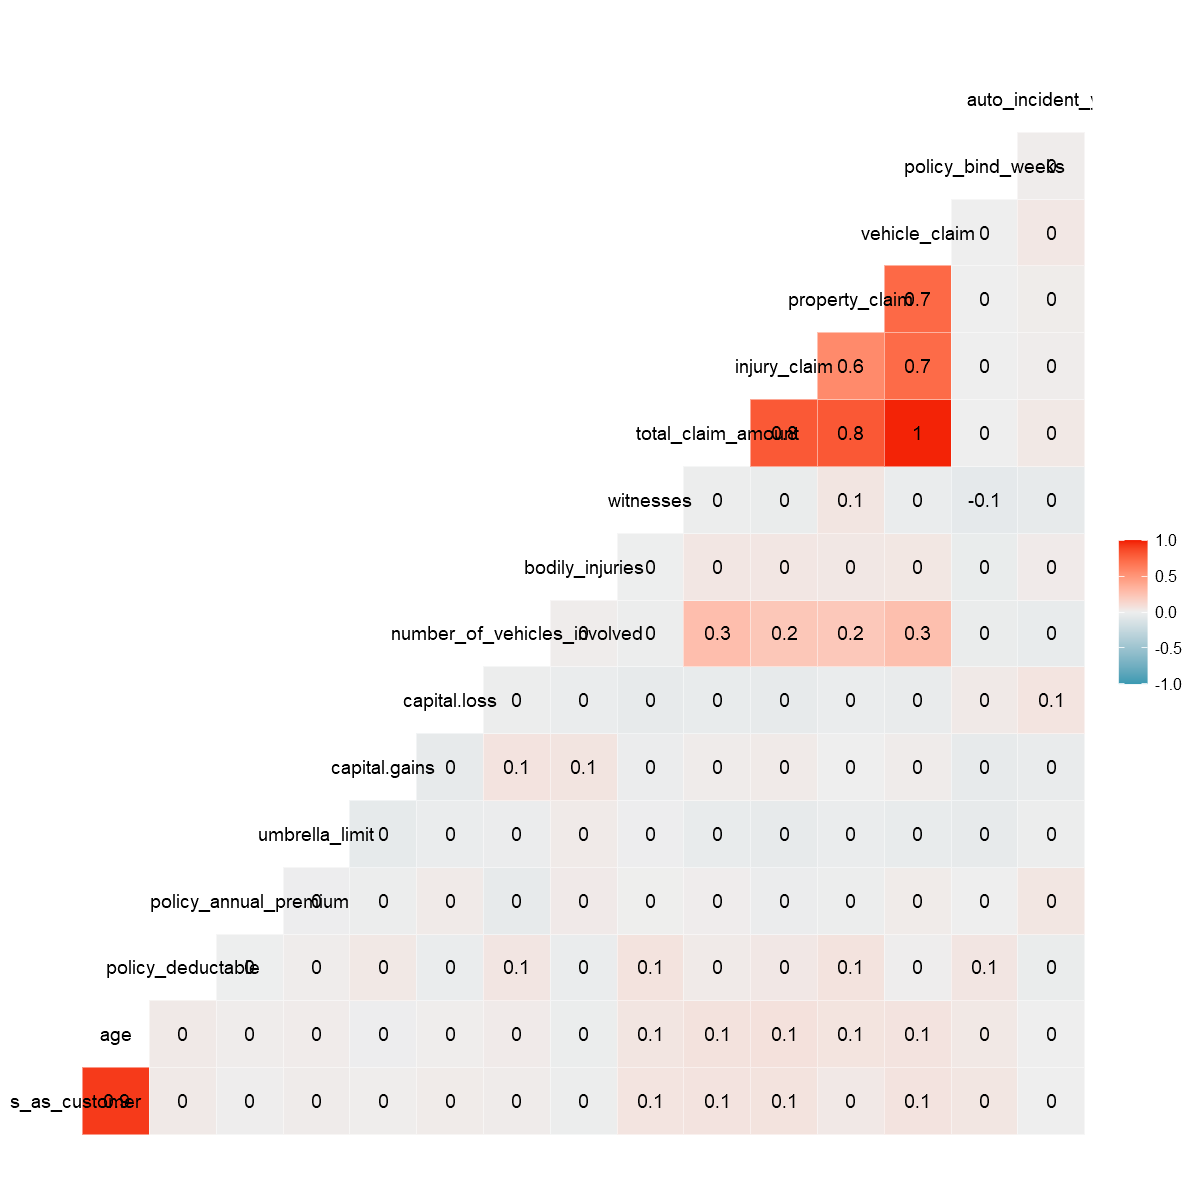

In [166]:
# Pearson linear correlation
options(repr.plot.width=10, repr.plot.height=10)
ggcorr(df_num_target %>% select(-c(fraud_reported)),method = c("pairwise", "pearson"),label="TRUE")

The heatmap reveals some linear positive correlations. Firstly between months_as_customer and age and secondly between three variables, namely total_claim_amount, injury_claim, and property_claim. There, the correlation is quite high, which is plausible for the latter since the total_claim_amount is supposedly the sum of injury_claim and property_claim. Concerning the months_as_customer you have to be of a certain age to at least have the chance of having a long customer relationship with the insurer. There is also another relatively high correlation, namely between number_of_vehicles_involved and the three named before (total_claim_amount, injury_claim, property_claim), but this is expected since the amount of damage is usually higher with more cars involved.

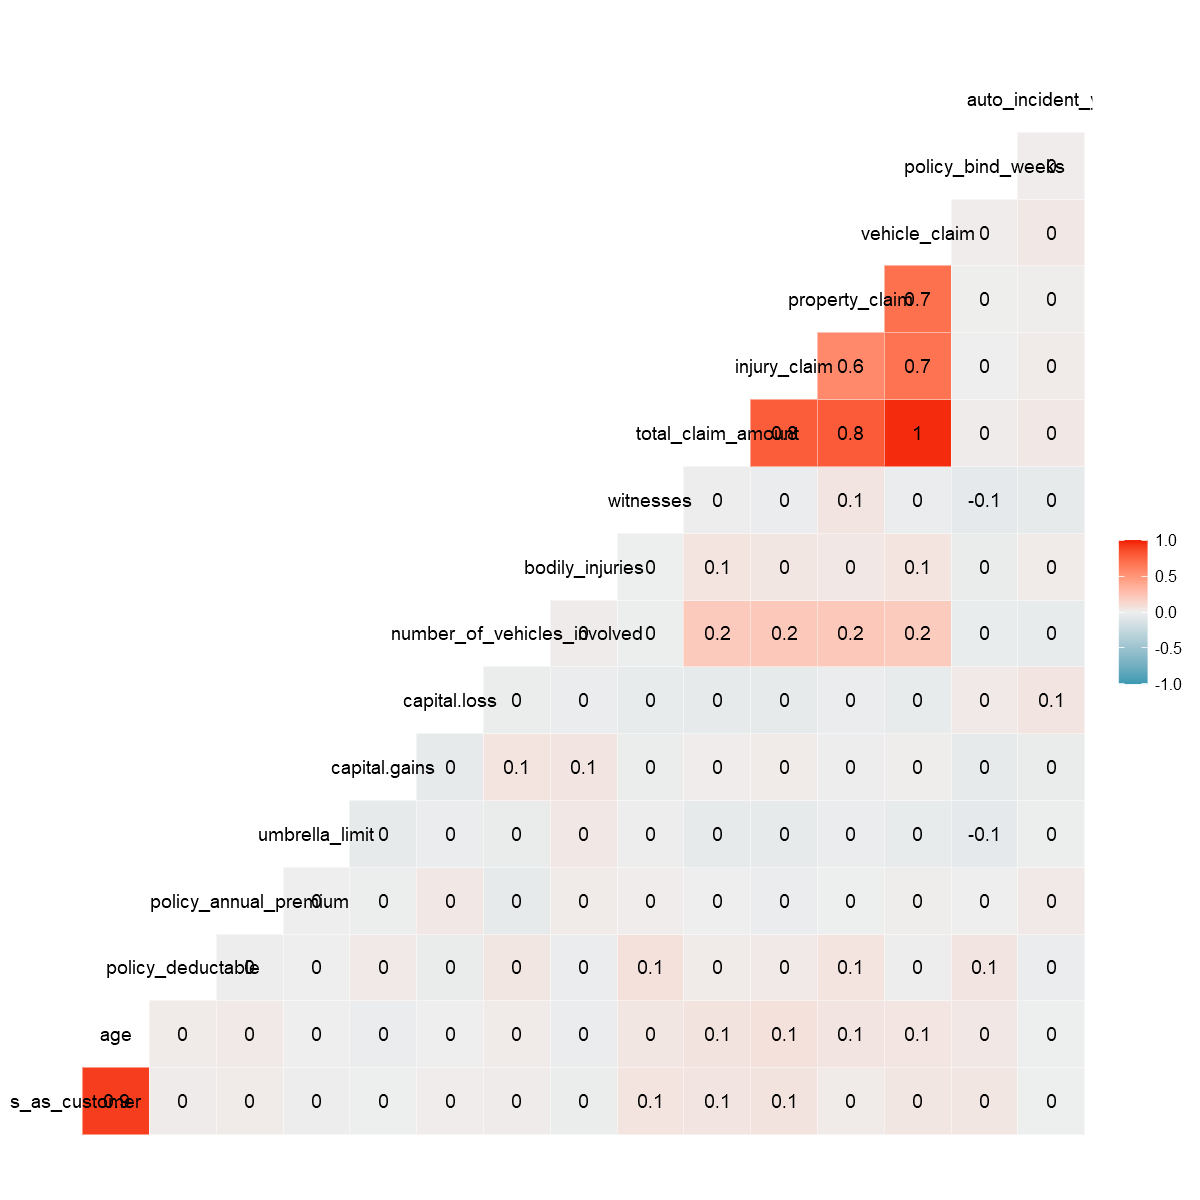

In [167]:
# Spearman rank correlation
options(repr.plot.width=10, repr.plot.height=10)
ggcorr(df_num_target %>% select(-c(fraud_reported)), method = c("pairwise", "spearman"),label=TRUE)

The spearman rank correlation reveals similar results as the default pearson correlation.

## 4. Prediction Models

We now want to derive models for predicting insurance fraud. Note that for real world applications, not all information (like the amount of damage or whether authorities are involved or not) is available immediately, e.g., when a customer reports a damage. In real world, a test for potential fraud would have to be conducted several times to detect fraud as early as possible. This is of course not the case in our analysis where we have all (past) data available at once.<br>

Before developing the models themselves, we again need to do some preparatory work like splitting the data into training and testing sets, introducing dummy variables, and limiting the number of variables. We do not generally conduct a standardization/normalization; if needed, this is done directly when applying the respective models. 

### 4.1 Dummy Variables

Since most machine learning algorithms are not able to properly deal with factor variables, we have to transform them into a suitable format. This is usually done via the introduction of dummy variables and one possibility for introducing dummies is the one hot encoding. Because we want to limit the number of variables in a subsequent step, one hot encoding is an adequate choice for generating the dummies. Via one hot encoding we get a (new) column for every value of the factor variables. The target variable must be excluded; it remains a factor variable.

In [28]:
# Data frame with both factor and numeric variables and adjusted columns
df_new <- data.frame(df_fac_new %>% select(-c(fraud_reported)),df_num_target %>% select(-c(fraud_reported)))

# Create dummy routine considering all values of the factor variables (no full rank)
dummies <- caret::dummyVars("~.",data=df_new,fullRank=FALSE)
# Apply dummy routine on the data 
df_dummies <- data.frame(predict(dummies, newdata=df_new),fraud_reported=df_fac_new[,"fraud_reported"])

In [29]:
# Show new data set with dummy variables (not all columns are included here)
head(df_dummies)
dim(df_dummies)

policy_state.IL policy_state.IN policy_state.OH policy_csl.100.300
1 0               0               1               0                 
2 0               1               0               0                 
3 0               0               1               1                 
4 1               0               0               0                 
5 1               0               0               0                 
6 0               0               1               0                 
  policy_csl.250.500 policy_csl.500.1000 insured_sex.FEMALE insured_sex.MALE
1 1                  0                   0                  1               
2 1                  0                   0                  1               
3 0                  0                   1                  0               
4 1                  0                   1                  0               
5 0                  1                   0                  1               
6 1                  0                   1                  0               
  insured_education_level.Associate insured_education_level.College
1 0                                 0                              
2 0                                 0                              
3 0                                 0                              
4 0                                 0                              
5 1                                 0                              
6 0                                 0                              
  insured_education_level.High.School insured_education_level.JD
1 0                                   0                         
2 0                                   0                         
3 0                                   0                         
4 0                                   0                         
5 0                                   0                         
6 0                                   0                         
  insured_education_level.Masters insured_education_level.MD
1 0                               1                         
2 0                               1                         
3 0                               0                         
4 0                               0                         
5 0                               0                         
6 0                               0                         
  insured_education_level.PhD insured_occupation.adm.clerical
1 0                           0                              
2 0                           0                              
3 1                           0                              
4 1                           0                              
5 0                           0                              
6 1                           0                              
  insured_occupation.armed.forces insured_occupation.craft.repair
1 0                               1                              
2 0                               0                              
3 0                               0                              
4 1                               0                              
5 0                               0                              
6 0                               0                              
  insured_occupation.exec.managerial insured_occupation.farming.fishing
1 0                                  0                                 
2 0                                  0                                 
3 0                                  0                                 
4 0                                  0                                 
5 0                                  0                                 
6 0                                  0                                 
  insured_occupation.handlers.cleaners insured_occupation.machine.op.inspct
1 0                                    0                                   
2 0                                    1                              

[1] 1000  189

We see that the number of columns has increased to 189.

### 4.2 Splitting the data

Before we train prediction models, we split the data set into two sets for training and testing so that we can more reliably assess the models' quality. Note that we omit an additional validation data set usually used for hyperparameter tuning since the data set is not that large (with only 1000 rows). We completely refrain from hyperparameter tuning in this notebook as it is not in the focus of the analysis. We concentrate more on the explainability part of the analysis. 
In omitting hyperparameter tuning, we cannot expect very good models, but for illustrating the interpretability aspect, this is not needed.

We split the data set with 80 % training data and 20 % test data with stratified sampling, i.e., the share of fraudulent claims in both sets should be approximately the same.

In [30]:
# Set seed for reproducability
set.seed(2021)

trainIndex <- createDataPartition(df_dummies[,"fraud_reported"], p = .8, list = FALSE, times = 1)

df_train <- df_dummies[trainIndex,]
df_test <- df_dummies[-trainIndex,]

In [31]:
# Check dimension of the two data sets and shares of the target variable
dim(df_train)
dim(df_test)
df_train %>% group_by(fraud_reported) %>% count
df_test %>% group_by(fraud_reported) %>% count

[1] 801 189

[1] 199 189

fraud_reported n  
1 N              603
2 Y              198

fraud_reported n  
1 N              150
2 Y               49

### 4.3 Variable Selection

For selecting relevant variables we use a fully automated approach. We first train a random forest with all variables and then assess their importance with two different methods. The variables in the top 30 of both methods are then used for further analyses and the actual prediction models. We will, of course, compare the relevant variables with the descriptive resp. explorative results from above. For the selection step, only the training data set is relevant.

In [32]:
# Setting for 5-fold cross validation with grid for hyperparameter optimization
ranger_cv <- trainControl(method = "cv",
                           number = 5)

ranger_grid <- expand.grid(.mtry = 2^(1:7),
                           .splitrule = c("extratrees","gini"),
                           .min.node.size = c(5, 10, 20))

In [33]:
set.seed(2021)

# Fit random forest with permutation importance
rf_fit1 <- train(fraud_reported  ~ ., data = df_train,
                     method = "ranger",
                     trControl = ranger_cv,
                     tuneGrid = ranger_grid,
                     num.trees = 200,
                     importance = "permutation")

rf_fit1

Random Forest 

801 samples
188 predictors
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 641, 642, 640, 640, 641 
Resampling results across tuning parameters:

  mtry  splitrule   min.node.size  Accuracy   Kappa        
    2   extratrees   5             0.7528145   0.000000e+00
    2   extratrees  10             0.7528145   0.000000e+00
    2   extratrees  20             0.7528145   0.000000e+00
    2   gini         5             0.7528145   0.000000e+00
    2   gini        10             0.7528145   0.000000e+00
    2   gini        20             0.7528145   0.000000e+00
    4   extratrees   5             0.7503300   3.261104e-05
    4   extratrees  10             0.7503145   2.016597e-02
    4   extratrees  20             0.7515723  -2.453611e-03
    4   gini         5             0.7490567  -7.355241e-03
    4   gini        10             0.7528068   1.504956e-02
    4   gini        20             0.7490879   2.985729e-03
 

In [34]:
set.seed(2021)

# Fit random forest with impurity importance
rf_fit2 <- train(fraud_reported  ~ ., data = df_train,
                     method = "ranger",
                     trControl = ranger_cv,
                     tuneGrid = ranger_grid,
                     num.trees = 200,
                     importance = "impurity")

rf_fit2

Random Forest 

801 samples
188 predictors
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 641, 642, 640, 640, 641 
Resampling results across tuning parameters:

  mtry  splitrule   min.node.size  Accuracy   Kappa        
    2   extratrees   5             0.7528145   0.000000e+00
    2   extratrees  10             0.7528145   0.000000e+00
    2   extratrees  20             0.7528145   0.000000e+00
    2   gini         5             0.7528145   0.000000e+00
    2   gini        10             0.7528145   0.000000e+00
    2   gini        20             0.7528145   0.000000e+00
    4   extratrees   5             0.7503300   3.261104e-05
    4   extratrees  10             0.7503145   2.016597e-02
    4   extratrees  20             0.7515723  -2.453611e-03
    4   gini         5             0.7490567  -7.355241e-03
    4   gini        10             0.7528068   1.504956e-02
    4   gini        20             0.7490879   2.985729e-03
 

In [172]:
# Variables with importance (permutation)
important_vars1 <- varImp(rf_fit1)
imp_vars1 <- important_vars1$importance %>% arrange(desc(Overall)) %>% top_n(30,wt=Overall)
imp_vars1

Overall   
incident_severity.Major.Damage       100.000000
insured_hobbies.chess                 57.240764
insured_hobbies.cross.fit             27.793116
incident_severity.Minor.Damage        16.988788
incident_severity.Total.Loss          16.915233
collision_type..                       3.548280
incident_hour_of_the_day.13            2.645761
insured_hobbies.golf                   1.919695
incident_severity.Trivial.Damage       1.788882
auto_model.92x                         1.709424
incident_month.3                       1.698699
vehicle_claim                          1.689617
insured_hobbies.camping                1.602004
insured_occupation.craft.repair        1.476035
insured_relationship.own.child         1.445438
insured_occupation.tech.support        1.419631
auto_model.X6                          1.413994
insured_relationship.not.in.family     1.314057
auto_make.Ford                         1.271488
insured_hobbies.yachting               1.239209
incident_state.SC                      1.232212
incident_hour_of_the_day.23            1.222371
insured_education_level.High.School    1.208691
auto_model.Malibu                      1.197484
incident_hour_of_the_day.12            1.182706
capital.gains                          1.151311
insured_occupation.handlers.cleaners   1.109137
auto_make.Accura                       1.109071
bodily_injuries                        1.094812
insured_sex.MALE                       1.082641

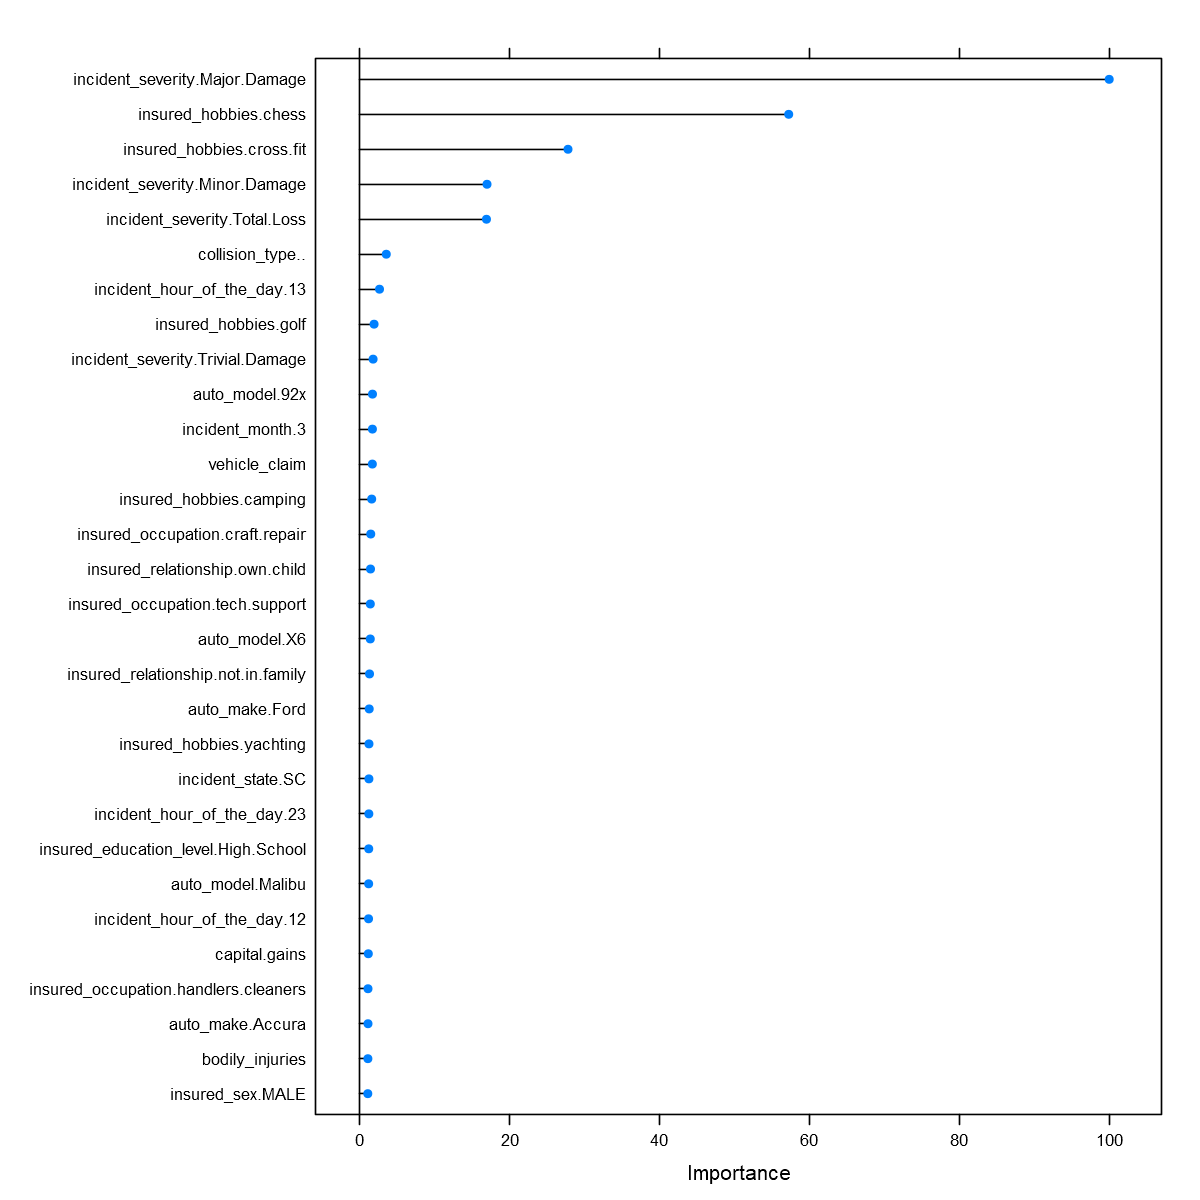

In [169]:
options(repr.plot.width=10, repr.plot.height=10)
plot(important_vars1,top=30)

In [171]:
# Variables with importance (impurity)
important_vars2 <- varImp(rf_fit2)
imp_vars2 <- important_vars2$importance %>% arrange(desc(Overall)) %>% top_n(30,wt=Overall)
imp_vars2

Overall   
incident_severity.Major.Damage       100.000000
insured_hobbies.chess                 53.277530
insured_hobbies.cross.fit             26.257855
incident_severity.Minor.Damage        11.391797
incident_severity.Total.Loss           9.648804
incident_hour_of_the_day.13            4.465312
bodily_injuries                        3.223569
insured_hobbies.camping                3.060298
incident_hour_of_the_day.12            2.836194
insured_hobbies.golf                   2.746134
incident_hour_of_the_day.23            2.619008
insured_relationship.own.child         2.610435
umbrella_limit                         2.529595
incident_month.3                       2.507238
collision_type..                       2.464546
auto_model.92x                         2.438295
insured_education_level.High.School    2.290875
insured_occupation.tech.support        2.289382
property_claim                         2.214948
insured_relationship.husband           2.214861
insured_occupation.exec.managerial     2.209491
collision_type.Rear.Collision          2.189843
insured_relationship.not.in.family     2.181857
insured_occupation.handlers.cleaners   2.181218
insured_hobbies.yachting               2.111633
total_claim_amount                     2.104899
insured_occupation.machine.op.inspct   2.098770
insured_education_level.JD             2.079507
policy_csl.100.300                     1.974773
auto_model.Civic                       1.929817

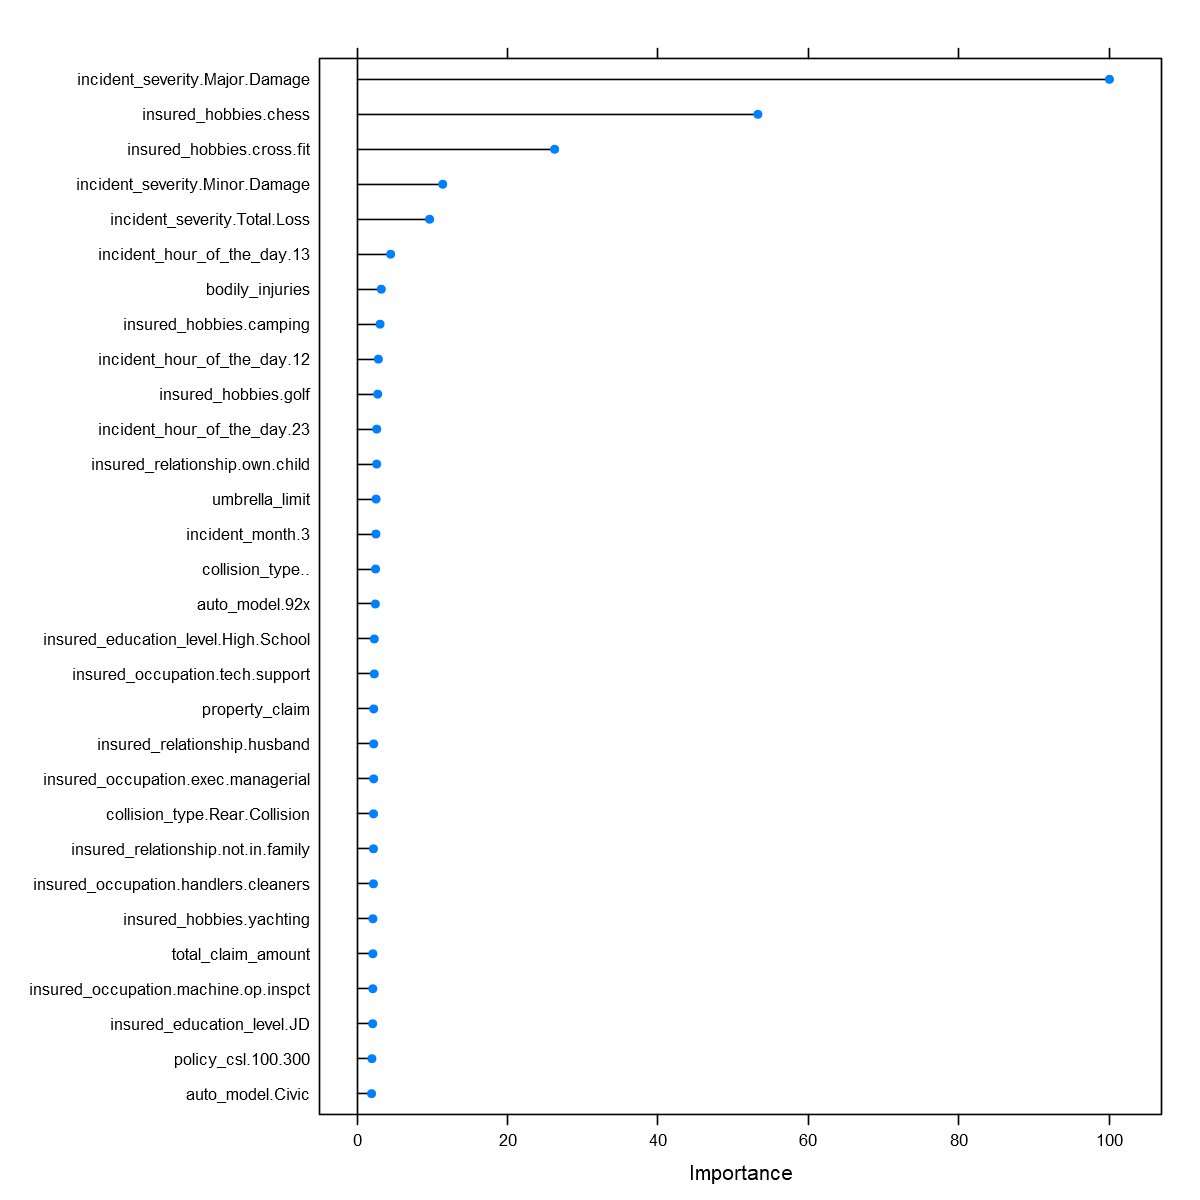

In [170]:
options(repr.plot.width=10, repr.plot.height=10)
plot(important_vars2,top=30)

The top 5 of both importance assessing methods are the same indicating that these variables are indeed relevant. Then, in both approaches, there is a strong decrease of the importance visible also in the plots. However, to not only use 5 variables in the further analyses, we take into account the top 30 of both methods (the union of them) as our univariate analysis also showed influences for other variables than the 5 listed as most important.

In [37]:
# Variables that are part of the top 30 in at least one of the importance assessing methods
imp_vars <- union(rownames(imp_vars1),rownames(imp_vars2))
imp_vars
length(imp_vars)

[1] "incident_severity.Major.Damage"      
 [2] "insured_hobbies.chess"               
 [3] "insured_hobbies.cross.fit"           
 [4] "incident_severity.Minor.Damage"      
 [5] "incident_severity.Total.Loss"        
 [6] "collision_type.."                    
 [7] "incident_hour_of_the_day.13"         
 [8] "insured_hobbies.golf"                
 [9] "incident_severity.Trivial.Damage"    
[10] "auto_model.92x"                      
[11] "incident_month.3"                    
[12] "vehicle_claim"                       
[13] "insured_hobbies.camping"             
[14] "insured_occupation.craft.repair"     
[15] "insured_relationship.own.child"      
[16] "insured_occupation.tech.support"     
[17] "auto_model.X6"                       
[18] "insured_relationship.not.in.family"  
[19] "auto_make.Ford"                      
[20] "insured_hobbies.yachting"            
[21] "incident_state.SC"                   
[22] "incident_hour_of_the_day.23"         
[23] "insured_education_level.High.School" 
[24] "auto_model.Malibu"                   
[25] "incident_hour_of_the_day.12"         
[26] "capital.gains"                       
[27] "insured_occupation.handlers.cleaners"
[28] "auto_make.Accura"                    
[29] "bodily_injuries"                     
[30] "insured_sex.MALE"                    
[31] "umbrella_limit"                      
[32] "property_claim"                      
[33] "insured_relationship.husband"        
[34] "insured_occupation.exec.managerial"  
[35] "collision_type.Rear.Collision"       
[36] "total_claim_amount"                  
[37] "insured_occupation.machine.op.inspct"
[38] "insured_education_level.JD"          
[39] "policy_csl.100.300"                  
[40] "auto_model.Civic"

[1] 40

We see that most of the variables are present in both lists. Also some highly correlated variables are present (vehicle_claim, property_claim, total_claim_amount). But since we do not know how the total_claim_amount is actually calculated and since the correlation is between 0.6 and 0.8, we do not exclude one of these variables.
With the above variables we determine our final training data set.

In [38]:
# Training data set with reduced number of variables
dftrain <- df_train[,c(imp_vars,"fraud_reported")]
dim(dftrain)

[1] 801  41

We explicitly do not drop dummy columns that lead to linear dependencies among the columns (when all values of the original categorical feature are present in the data set as an own dummy column) as this may lead to unwanted results later on, especially when using, e.g., tree-based machine learning methods. A rank deficiency is not problematic unless we refrain from closed-from solutions for regression models (see https://inmachineswetrust.com/posts/drop-first-columns/#cell5).
Here, for example, the incident_severity is fully present in the data set.

### 4.4 Logistic Regression Model

As a first comparably simple model we train a logistic regression model. There are no hyperparameters to be optimized.

In [39]:
# Setting for 5-fold cross validation with grid for hyperparameter optimization
logreg_cv <- trainControl(method = "cv",
                           number = 5)

set.seed(2021)

logreg_fit <- train(fraud_reported  ~ ., data = dftrain,
                    method = "glm",
                    family = "binomial",
                    trControl = logreg_cv)

logreg_fit

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Generalized Linear Model 

801 samples
 40 predictor
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 641, 642, 640, 640, 641 
Resampling results:

  Accuracy   Kappa    
  0.8526838  0.5970506


Note that the warning messages hint at the fact that some columns of our data set are linearly dependent. The classes are in the "right order": N/Y -> 0/1. So the interpretation of the model is according to our natural understanding. 

In [40]:
# Predict on test data with logistic regression model
logreg_pred <- predict(logreg_fit, newdata = df_test)

confusionMatrix(data = logreg_pred, reference = df_test[,"fraud_reported"],positive='Y')

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N 132  16
         Y  18  33
                                          
               Accuracy : 0.8291          
                 95% CI : (0.7695, 0.8787)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.006868        
                                          
                  Kappa : 0.546           
                                          
 Mcnemar's Test P-Value : 0.863832        
                                          
            Sensitivity : 0.6735          
            Specificity : 0.8800          
         Pos Pred Value : 0.6471          
         Neg Pred Value : 0.8919          
             Prevalence : 0.2462          
         Detection Rate : 0.1658          
   Detection Prevalence : 0.2563          
      Balanced Accuracy : 0.7767          
                                          
       'Positive' Class : Y               
                              

The model has an accuracy of almost 83% on the test data (compared to about 85% on the training data, which is an acceptable decrease in accuracy) where the detection prevalence, i.e. the number of predicted positive events (both true positive and false positive) divided by the total number of predictions, is about 25%. This is more or less the real share of fraud cases, i.e., the threshold of the target probabilities for distiguishing between fraud and non-fraud seems to be well set.

Regarding the logistic regression model, we can have a look at the coefficients to get an impression of how the model works and to interprete especially the results of the test data. The absolute numbers are on a log-odds scale and not easy to understand or interprete, but it is informative enough to see whether they are positive/negative and how they are ordered. The interpretation of the logistic regression model itself is not in the (direct) focus of this notebook.

In [41]:
# Coefficient values ordered (with respect to their absolute values)
logreg_fit$finalModel$coefficients[order(abs(logreg_fit$finalModel$coefficients),decreasing = TRUE)]

insured_hobbies.chess                          (Intercept) 
                        5.099663e+00                        -4.104132e+00 
      incident_severity.Major.Damage            insured_hobbies.cross.fit 
                        3.960339e+00                         3.204302e+00 
                       auto_model.X6              insured_hobbies.camping 
                        1.845817e+00                        -1.306642e+00 
         incident_hour_of_the_day.12          incident_hour_of_the_day.13 
                       -1.286055e+00                        -1.249836e+00 
            insured_hobbies.yachting                    auto_model.Malibu 
                        1.248707e+00                        -1.193814e+00 
                      auto_model.92x                     auto_model.Civic 
                       -1.102362e+00                         1.078985e+00 
                    auto_make.Accura      insured_occupation.craft.repair 
                       -9.984915e-01                         8.706534e-01 
  insured_occupation.exec.managerial         insured_relationship.husband 
                        7.934624e-01                        -7.740693e-01 
       collision_type.Rear.Collision         incident_severity.Total.Loss 
                        6.569793e-01                         6.349450e-01 
         incident_hour_of_the_day.23                 insured_hobbies.golf 
                        6.334768e-01                        -6.037513e-01 
      incident_severity.Minor.Damage insured_occupation.handlers.cleaners 
                        6.024819e-01                        -5.918008e-01 
                    incident_month.3       insured_relationship.own.child 
                       -5.821818e-01                        -5.485299e-01 
                    collision_type..   insured_relationship.not.in.family 
                        4.008462e-01                         3.465993e-01 
          insured_education_level.JD      insured_occupation.tech.support 
                        3.446341e-01                         2.761626e-01 
                      auto_make.Ford  insured_education_level.High.School 
                       -2.482421e-01                        -2.380212e-01 
                     bodily_injuries                    incident_state.SC 
                        1.923120e-01                         1.884482e-01 
                    insured_sex.MALE insured_occupation.machine.op.inspct 
                        9.996661e-02                        -9.627541e-02 
                  policy_csl.100.300                        vehicle_claim 
                       -9.476707e-02                         6.017249e-05 
                  total_claim_amount                       property_claim 
                       -4.410368e-05                         2.776051e-05 
                       capital.gains                       umbrella_limit 
                       -4.660742e-06                         1.171727e-07 
    incident_severity.Trivial.Damage 
                                  NA

The baseline (the intercept) is a relatively high negative coefficient value, i.e., the model starts from the premise that the claim is not fraudulent. However, when the hobby of the insured is chess (compared to other hobbies), the negative baseline is prevailed. Note that the trivial damage for the incident_severity is NA (due to a linear dependence), which means that this value of the incident_severity has no effect (its effect is already present in the intercept). The coefficient values for the numeric columns are comparably small, but they reflect the effect when changing the value of the numeric column by 1. A projection to the whole range would be necessary to assess the possible effects of these variables. 

### 4.5 Gradient Boosting Model

As second model, we train a gradient boosting model (from the h2o package) and use again a five fold cross validation for setting some of the hyperparameters. As this optimization takes quite a lot of time, there is also the possibility to directly train the final model resulting from the CV approach.

In [42]:
# Grid with different hyperparameter settings
gbm_grid <- expand.grid(.ntrees = c(50,100),
                        .max_depth = c(5,10,20),
                        .min_rows = c(5,25,30),
                        .learn_rate = c(0.001,0.01,0.1,0.2),
                        .col_sample_rate = c(0.5,0.75,0.9,1))

nrow(gbm_grid)

[1] 288

In [43]:
# Setting for 5-fold cross validation with grid for hyperparameter optimization
gbm_cv <- trainControl(method = "cv",
                       number = 5)

set.seed(2021)

gbm_fit <- train(fraud_reported  ~ ., data = dftrain,
                 method = "gbm_h2o",
                 #family = "binomial",
                 trControl = gbm_cv,
                 tuneGrid = gbm_grid)

gbm_fit

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in .h2o.__checkConnectionHealth():
"H2O cluster node 127.0.0.1:54321 is behaving slowly and should be inspected manually"Warning message in .h2o.__checkConnectionHealth():
"Check H2O cluster status here: http://localhost:54321/3/Cloud?skip_ticks=true
"Warning message in .h2o.__checkConnectionHealth():
"H2O cluster node 127.0.0.1:54321 is behaving slowly and should be inspected manually"Warning message in .h2o.__checkConnectionHealth():
"Check H2O cluster status here: http://localhost:54321/3/Cloud?skip_ticks=true
"Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Gradient Boosting Machines 

801 samples
 40 predictor
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 641, 642, 640, 640, 641 
Resampling results across tuning parameters:

  ntrees  max_depth  min_rows  learn_rate  col_sample_rate  Accuracy 
   50      5          5        0.001       0.50             0.8302457
   50      5          5        0.001       0.75             0.8390116
   50      5          5        0.001       0.90             0.8377538
   50      5          5        0.001       1.00             0.8402460
   50      5          5        0.010       0.50             0.8389725
   50      5          5        0.010       0.75             0.8414649
   50      5          5        0.010       0.90             0.8402148
   50      5          5        0.010       1.00             0.8402070
   50      5          5        0.100       0.50             0.8440117
   50      5          5        0.100       0.75             0.8427382

For avoiding a repetition of the hyperparameter optimization of the GBM in the development phase we wanted to pass seeds to the gradient boosting training function in the trainControl function, but this did not work as expected. So we saved the final model from the optimization to be able to load it again. The code parts can be uncommented if necessary.

In [44]:
## Not run:
# save optimized model from above in development phase
#saveRDS(gbm_fit,file = "gbm_fit.rds")

In [45]:
## Not run:
# load saved GBM
#gbm_fit_load <- readRDS(file="gbm_fit.rds")

In [46]:
## Not run:
#gbm_fit_load

Gradient Boosting Machines 

801 samples
 40 predictor
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 641, 642, 640, 640, 641 
Resampling results across tuning parameters:

  ntrees  max_depth  min_rows  learn_rate  col_sample_rate  Accuracy 
   50      5          5        0.001       0.50             0.8302457
   50      5          5        0.001       0.75             0.8390116
   50      5          5        0.001       0.90             0.8377538
   50      5          5        0.001       1.00             0.8402460
   50      5          5        0.010       0.50             0.8389725
   50      5          5        0.010       0.75             0.8414649
   50      5          5        0.010       0.90             0.8402148
   50      5          5        0.010       1.00             0.8402070
   50      5          5        0.100       0.50             0.8440117
   50      5          5        0.100       0.75             0.8427382

In [175]:
# Rename so that the model loading does not override the model resulting from the optimization  
# Only rename when optimization was conducted
if (exists("gbm_fit")){
    gbm_fit_load <- gbm_fit
    }

In [47]:
# Predict with the GBM on test data
gbm_pred <- predict(gbm_fit_load, newdata = df_test)

confusionMatrix(data = gbm_pred, reference = df_test[,"fraud_reported"],positive='Y')

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N 134  22
         Y  16  27
                                          
               Accuracy : 0.809           
                 95% CI : (0.7475, 0.8612)
    No Information Rate : 0.7538          
    P-Value [Acc > NIR] : 0.03925         
                                          
                  Kappa : 0.4635          
                                          
 Mcnemar's Test P-Value : 0.41730         
                                          
            Sensitivity : 0.5510          
            Specificity : 0.8933          
         Pos Pred Value : 0.6279          
         Neg Pred Value : 0.8590          
             Prevalence : 0.2462          
         Detection Rate : 0.1357          
   Detection Prevalence : 0.2161          
      Balanced Accuracy : 0.7222          
                                          
       'Positive' Class : Y               
                              

We see that the tree-based gradient boosting method (GBM) has a lower accuracy on the test data than the logistic regression model (LRM) (80.9% vs. 82.01%). The performances of the two methods on the training data is about the same (84.52% and 85.27%; also a slight advantage of the LRM). <br><br>
When comparing these two models, there would be no need for the GBM. However, some robustness checks with other seeds revealed a certain volatility in the final GBM models. This may also come from the fact that our grid for the hyperparameter optimization is quite rough and that our dataset is quite small. Using a finer grid is not possible since we have limited computing power which is why we stick to the GBM as it is for the moment. For the illustration of the model explanations and its interpretability the actual performance/accuracy is not that important. 

In [48]:
# A final overview of the performance of the two models 
summary(resamples(list(LRM=logreg_fit, GBM=gbm_fit)))


Call:
summary.resamples(object = resamples(list(LRM = logreg_fit, GBM = gbm_fit)))

Models: LRM, GBM 
Number of resamples: 5 

Accuracy 
         Min.   1st Qu.    Median      Mean   3rd Qu.    Max. NA's
LRM 0.8012422 0.8250000 0.8364780 0.8526838 0.8881988 0.91250    0
GBM 0.8187500 0.8198758 0.8427673 0.8452149 0.8509317 0.89375    0

Kappa 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LRM 0.4677686 0.4992175 0.5583333 0.5970506 0.7055477 0.7543860    0
GBM 0.5126050 0.5135952 0.5929339 0.5894349 0.6137545 0.7142857    0


We may understand the LRM's decisions by looking at the coefficients of the linear model, but the functioning of the GBM is not that easy to see. Here is where we want to use local interpretable model-agnostic explanations (LIME).

## 5. Local Model-Agnostic Explanations (LIME) 

LIME is an explanation approach suitable for all kinds of models (as the part "model-agnostic" may suggest). It basically works as follows: A (non interpretable) prediction model is given (in our case the GBM). It was trained on the whole training data set and performs quite well. Explanations should now be given for single lines of data, i.e., each decision of the prediction model is explained separately. For each line of data, a set (called neighborhood) of similar lines of data is determined (real data or artificial perturbations) and a less complex, interpretable model is trained on this neighborhood (local model) where the target variable is not the original variable but the output of the prediction model on the neighborhood. This local model may be used for interpreting the decision of the prediction model.

R offers the lime package (a port of the lime Python package). When using this package, an explainer is trained using the "lime" function. As input it takes, among others, the original training data and the (already trained) model to be explained.  The best explainer is found through an optimization approach: The explainer model is the model that minimizes the loss (e.g., the mean squared error between the prediction model's predictions and a local model's predictions) while its complexity is kept low (i.e., its interpretability is high). However, a model family (or a set of model families) that should be used for the explanations cannot be stated. For example, we cannot instruct the function to use only logistic regression models as explainers. For determining the neighborhood, we are able to specify the number of neighbors (presumably generated through permutations) and the distance measure for weighting the neighbors (more distant neighbors receive lower weights).

### 5.1 Explaining the GBM

In [147]:
# Create the explainer (the function that is to be optimized in the LIME approach)
# For the explanations we want to have the continuous variables binned as this is supposedly easier to understand
# The number of bins is (arbitrarily) set to 7
explainer <- lime(x = dftrain,model = gbm_fit_load,bin_continuous = TRUE,n_bins = 7,quantile_bins = FALSE)

In [151]:
# Create the explanation (optimize the function)
# n_features (the number of features) is just limited for visualization
# n_permutations (the number of neighbors) influences the explainer model
# For readability we also stick to the first ten entries of the test dataset

set.seed(2021)
explanation <- explain(x = df_test[1:10,imp_vars],explainer = explainer,labels = c("Y"),n_features = 10,n_permutations = 1000)

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."

  |======================================================================| 100%
  |======================================================================| 100%


When looking at the explanation, we get prediction explanations in table format, one observation, i.e., one feature of one case, per row. 

In [152]:
# Explanations in table format
explanation

model_type     case label label_prob model_r2   model_intercept
1   classification 5    Y     0.2253955  0.31237333 0.2291563      
2   classification 5    Y     0.2253955  0.31237333 0.2291563      
3   classification 5    Y     0.2253955  0.31237333 0.2291563      
4   classification 5    Y     0.2253955  0.31237333 0.2291563      
5   classification 5    Y     0.2253955  0.31237333 0.2291563      
6   classification 5    Y     0.2253955  0.31237333 0.2291563      
7   classification 5    Y     0.2253955  0.31237333 0.2291563      
8   classification 5    Y     0.2253955  0.31237333 0.2291563      
9   classification 5    Y     0.2253955  0.31237333 0.2291563      
10  classification 5    Y     0.2253955  0.31237333 0.2291563      
11  classification 10   Y     0.2291808  0.18837939 0.2285876      
12  classification 10   Y     0.2291808  0.18837939 0.2285876      
13  classification 10   Y     0.2291808  0.18837939 0.2285876      
14  classification 10   Y     0.2291808  0.18837939 0.2285876      
15  classification 10   Y     0.2291808  0.18837939 0.2285876      
16  classification 10   Y     0.2291808  0.18837939 0.2285876      
17  classification 10   Y     0.2291808  0.18837939 0.2285876      
18  classification 10   Y     0.2291808  0.18837939 0.2285876      
19  classification 10   Y     0.2291808  0.18837939 0.2285876      
20  classification 10   Y     0.2291808  0.18837939 0.2285876      
21  classification 15   Y     0.2291808  0.03753046 0.2283306      
22  classification 15   Y     0.2291808  0.03753046 0.2283306      
23  classification 15   Y     0.2291808  0.03753046 0.2283306      
24  classification 15   Y     0.2291808  0.03753046 0.2283306      
25  classification 15   Y     0.2291808  0.03753046 0.2283306      
26  classification 15   Y     0.2291808  0.03753046 0.2283306      
27  classification 15   Y     0.2291808  0.03753046 0.2283306      
28  classification 15   Y     0.2291808  0.03753046 0.2283306      
29  classification 15   Y     0.2291808  0.03753046 0.2283306      
30  classification 15   Y     0.2291808  0.03753046 0.2283306      
31  classification 16   Y     0.2905054  0.65312817 0.2280100      
32  classification 16   Y     0.2905054  0.65312817 0.2280100      
33  classification 16   Y     0.2905054  0.65312817 0.2280100      
34  classification 16   Y     0.2905054  0.65312817 0.2280100      
35  classification 16   Y     0.2905054  0.65312817 0.2280100      
36  classification 16   Y     0.2905054  0.65312817 0.2280100      
37  classification 16   Y     0.2905054  0.65312817 0.2280100      
38  classification 16   Y     0.2905054  0.65312817 0.2280100      
39  classification 16   Y     0.2905054  0.65312817 0.2280100      
40  classification 16   Y     0.2905054  0.65312817 0.2280100      
41  classification 20   Y     0.2726429  0.58274362 0.2280812      
42  classification 20   Y     0.2726429  0.58274362 0.2280812      
43  classification 20   Y     0.2726429  0.58274362 0.2280812      
44  classification 20   Y     0.2726429  0.58274362 0.2280812      
45  classification 20   Y     0.2726429  0.58274362 0.2280812      
46  classification 20   Y     0.2726429  0.58274362 0.2280812      
47  classification 20   Y     0.2726429  0.58274362 0.2280812      
48  classification 20   Y     0.2726429  0.58274362 0.2280812      
49  classification 20   Y     0.2726429  0.58274362 0.2280812      
50  classification 20   Y     0.2726429  0.58274362 0.2280812      
51  classification 26   Y     0.2923317  0.81523585 0.2282118      
52  classification 26   Y     0.2923317  0.81523585 0.2282118      
53  classification 26   Y     0.2923317  0.81523585 0.2282118      
54  classification 26   Y     0.2923317  0.81523585 0.2282118      
55  classification 26   Y     0.2923317  0.81523585 0.2282118      
56  classification 26   Y     0.2923317  0.81523585 0.2282118      
57  classification 26   Y     0.2923317  0.81523585 0.2282118      
58  classification 26   Y     0.2923317  0.81523585 0.228211

Here is what the columns mean:
 - model_type: lime guessed right that we do classification
 - case: the number of the case (the rowname in the dataset; the rownames are carried over here from the original data set before the splitting into train and test)
 - label: the label that should be explained (we are looking for explanations supporting fraudulent behavior, which is the reverse of label = "N", so it is just the view we specify here)
 - label_prob: the probability of the label (Y) in the original model (GBM)
 - model_r2: the model quality of the explainer
 - model_intercept: the intercept of the explainer
 - model_prediction: the probability of the label (Y) as assessed by the explainer
 - feature: the feature we consider
 - feature_value: the feature value in the dataset
 - feature_weight: the feature weight as assessed by the explainer (here, positive values support fraud, negative values indicate no fraud)
 - feature_desc: a better human readable description of the feature importance. The dummyfied features are treated as numeric features here and are thus binned (as stated in the explainer function lime); so their readability is not really improved here. "Real" numeric features are binned as well and here it would be meaningful name the bins like "medium total_claim_amount" or "very high total_claim_amount" (with interval definitions of "medium" or "very high").
 - data: the case data (data row) of the feature we are looking at
 - prediction: the original prediction from the model (probabilities for all label values; ("N","Y") here)

As the table format is not very lucid, we may visually plot the explanations (i.e., the feature weights). The lime package offers two visualization methods for tabular data, an overview visualization and a more detailed one. As reference, we also print the real labels in the test data and the labels predicted by the model.

In [153]:
# The labels as they are in the test data set and as they are predicted by the GBM for the first few cases
print("Labels in test data:")
df_test[1:10,"fraud_reported"]
print("Labels predicted by the model:")
gbm_pred[1:10]

[1] "Labels in test data:"


[1] N N Y Y N Y N Y N N
Levels: N Y

[1] "Labels predicted by the model:"


[1] N N N Y N Y N Y N N
Levels: N Y

In this first ten test cases only one prediction of the GBM is wrong.

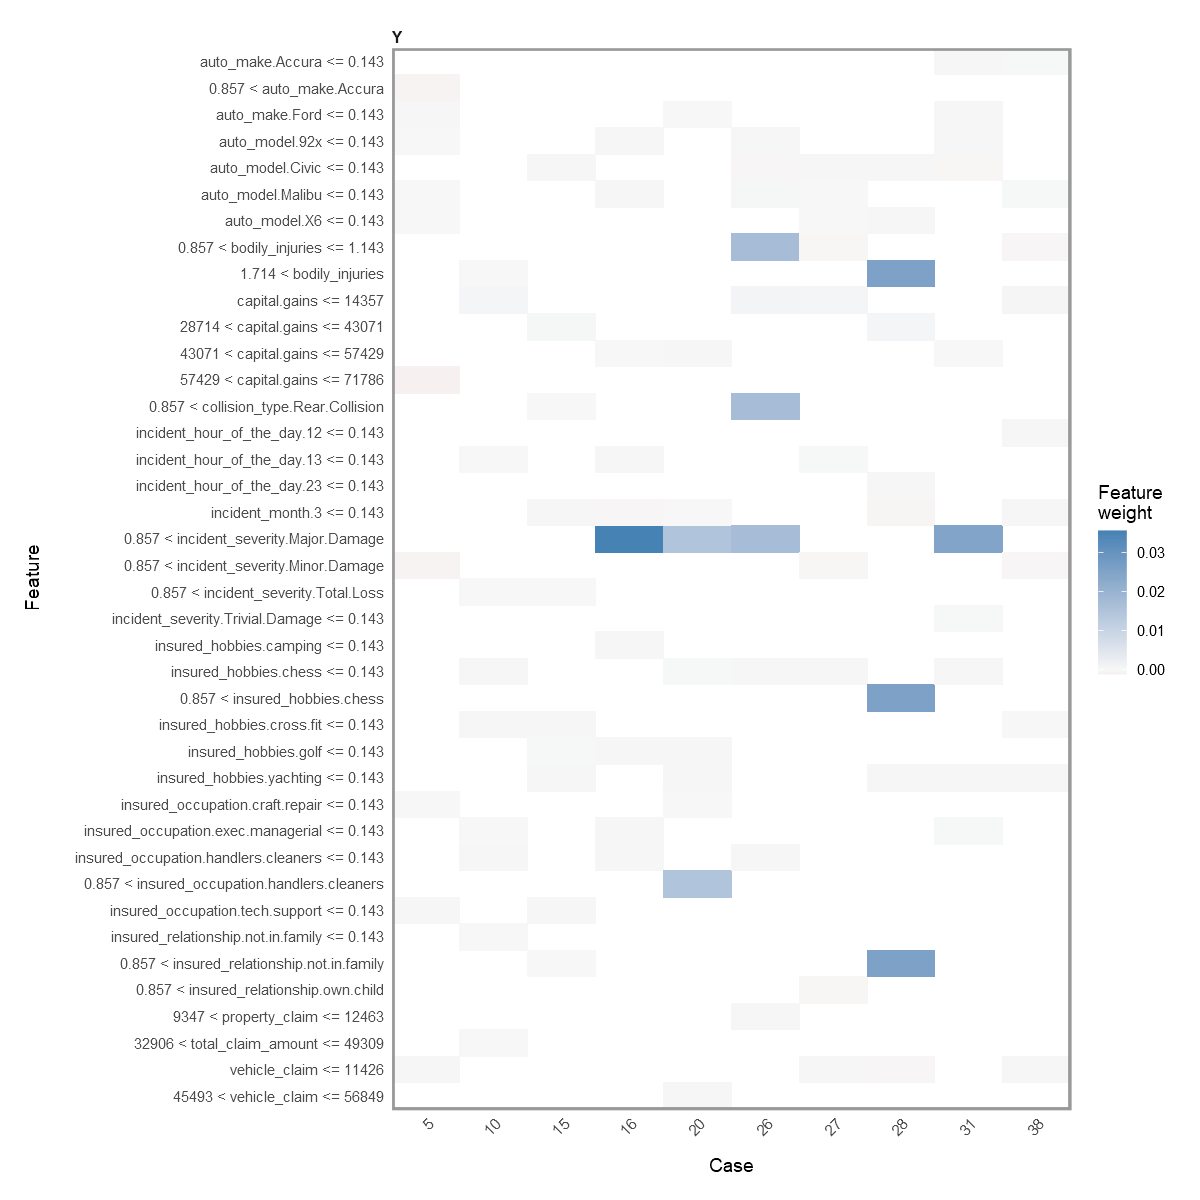

In [177]:
# Overview heatmap with the feature weights supporting or contradicting a positive label
options(repr.plot.width=10, repr.plot.height=10)
plot_explanations(explanation)

On the left hand side of the plot, we see the feature description (the "human readable" version of the feature from the table view above). Although there are features that support non fraud, we see that the weights supporting fraud are more dominant; their absolute values are much higher. <br><br>
The more detailed plot gives better insights into the explainer's decision. It lists the features according to their importance and whether they support fraud or non-fraud.

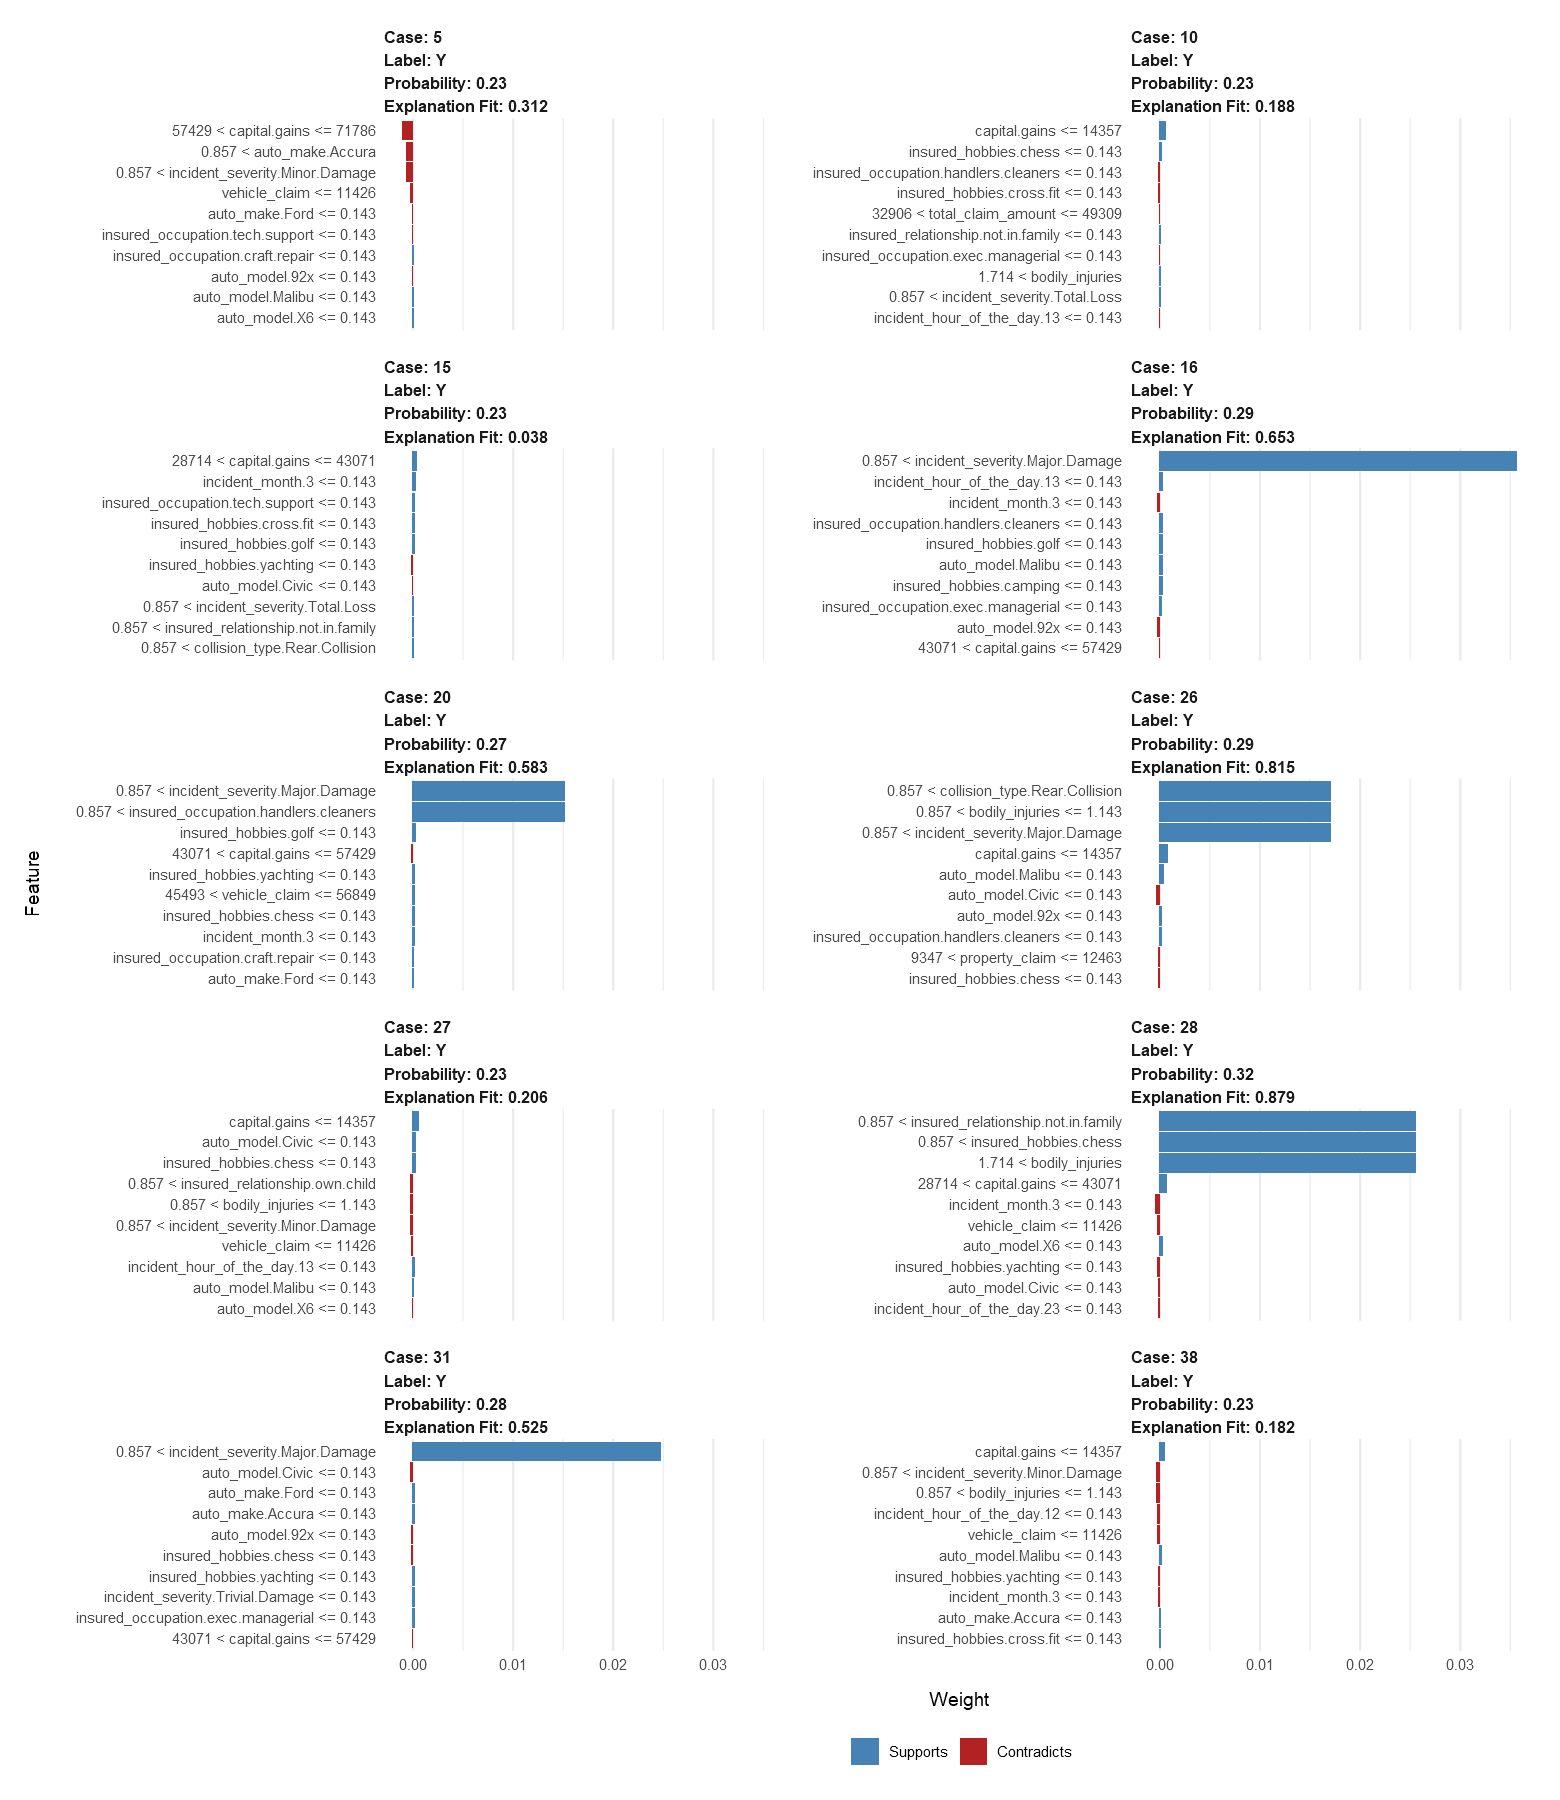

In [155]:
# visualization with more details (features supporting and contradicting a positive label)
options(repr.plot.width = 13, repr.plot.height = 15) # set plot size in jupyter notebook
plot_features(explanation)

"Probability" is again the label probability assessed by the original model (GBM). The "Explanation Fit" seems not to be the same as the model_r2 from the tabular depiction, but it also seems to be a measure for the quality of the explainer model. For example, the explainers for cases 16, 26, and 28 have a very high Explanation Fit and the long blue bars for the most important features strongly support fraud. Thus, the explainer supports fraud and it is also very certain that this decision is right. Remember that the reference for the explainer is the decision of the original model, not the "true value". <br><br> 
Cases 20 and 31 also have one or two quite long blue bars at the top, but both the original model's and the explainer's decision is for non-fraud. Here, it is not so clear why the decision was made in favor of non-fraud. The Explanation Fits are medium high (so the explainer's explanation is not fully reliable) and "only" one feature strongly supporting fraud (case 31) or two features with medium high weights (case 20) do not seem enough.<br><br>
Case 15 (the third one in the test data) is interesting. It is a fraudulent case (as the label in the test data tells us), but the GBM does not assess fraud (actually, the fraud probability modeled with the GBM is about 23%). The Explanation Fit of the explainer for this case is the lowest of the ten explanations above; it is nearly 0. This means that the explainer is not confident that the assessment of non-fraud is right. It doesn't find a convincing explanation for non-fraud. This may also be a hint that the assessment of the model was not right. It may be that a convincing explanation lies in one of the features we excluded during the data preparation phase or that there is no explanation within the given data at all. It would be interesting to inspect similar cases (similar features) and their targets.<br><br>
As already seen in the overview, it seems to be easier to find explanations for fraud than for non-fraud. Only for the first case (case 5) in our ten examples we get more or less clear explanations why it is not a fraudulent case. This behavior is also an implication of the many dummy variables. A situation where (many) dummy variables are 0 (or <=0.143 in our case because of the seven bins of numeric variables) could be called a standard situation. Take, for example, case 31. The most important variable here is incident_severity.Major.Damage=1, but this is the only positive dummy. All others are 0: the incident_hour was not 12, the insured_occupation was not handlers.cleaners, the insured_hobbies was not golf, and so on. This is understandably no valuable information (but there seems to be no other real valuable one than the major damage).

### 5.2 Explaining the LRM

As we cannot restrict the explanations to logistic regression models, we do a little workaround to be able to compare the results of the LRM and the GBM, especially the cases where the assessment of the two models differ. That is, we also generate an explainer for the LRM. We can then compare the two explainers' explanations as well as the LRM's explainer and the LRM itself.

In [156]:
# Explainer function for the LRM
explainer_lrm <- lime(x = dftrain,model = logreg_fit,bin_continuous = TRUE,n_bins = 7,quantile_bins = FALSE)
set.seed(2021)
explanation_lrm <- explain(x = df_test[1:10,imp_vars],explainer = explainer_lrm,labels = c("Y"),n_features = 10,n_permutations = 1000)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

In [157]:
# Explanation in table format
explanation_lrm

model_type     case label label_prob model_r2   model_intercept
1   classification 5    Y     0.02662946 0.50814646 0.3670970      
2   classification 5    Y     0.02662946 0.50814646 0.3670970      
3   classification 5    Y     0.02662946 0.50814646 0.3670970      
4   classification 5    Y     0.02662946 0.50814646 0.3670970      
5   classification 5    Y     0.02662946 0.50814646 0.3670970      
6   classification 5    Y     0.02662946 0.50814646 0.3670970      
7   classification 5    Y     0.02662946 0.50814646 0.3670970      
8   classification 5    Y     0.02662946 0.50814646 0.3670970      
9   classification 5    Y     0.02662946 0.50814646 0.3670970      
10  classification 5    Y     0.02662946 0.50814646 0.3670970      
11  classification 10   Y     0.01008245 0.08037098 0.2090622      
12  classification 10   Y     0.01008245 0.08037098 0.2090622      
13  classification 10   Y     0.01008245 0.08037098 0.2090622      
14  classification 10   Y     0.01008245 0.08037098 0.2090622      
15  classification 10   Y     0.01008245 0.08037098 0.2090622      
16  classification 10   Y     0.01008245 0.08037098 0.2090622      
17  classification 10   Y     0.01008245 0.08037098 0.2090622      
18  classification 10   Y     0.01008245 0.08037098 0.2090622      
19  classification 10   Y     0.01008245 0.08037098 0.2090622      
20  classification 10   Y     0.01008245 0.08037098 0.2090622      
21  classification 15   Y     0.02571608 0.06940414 0.3144590      
22  classification 15   Y     0.02571608 0.06940414 0.3144590      
23  classification 15   Y     0.02571608 0.06940414 0.3144590      
24  classification 15   Y     0.02571608 0.06940414 0.3144590      
25  classification 15   Y     0.02571608 0.06940414 0.3144590      
26  classification 15   Y     0.02571608 0.06940414 0.3144590      
27  classification 15   Y     0.02571608 0.06940414 0.3144590      
28  classification 15   Y     0.02571608 0.06940414 0.3144590      
29  classification 15   Y     0.02571608 0.06940414 0.3144590      
30  classification 15   Y     0.02571608 0.06940414 0.3144590      
31  classification 16   Y     0.06051527 0.09512598 0.3364009      
32  classification 16   Y     0.06051527 0.09512598 0.3364009      
33  classification 16   Y     0.06051527 0.09512598 0.3364009      
34  classification 16   Y     0.06051527 0.09512598 0.3364009      
35  classification 16   Y     0.06051527 0.09512598 0.3364009      
36  classification 16   Y     0.06051527 0.09512598 0.3364009      
37  classification 16   Y     0.06051527 0.09512598 0.3364009      
38  classification 16   Y     0.06051527 0.09512598 0.3364009      
39  classification 16   Y     0.06051527 0.09512598 0.3364009      
40  classification 16   Y     0.06051527 0.09512598 0.3364009      
41  classification 20   Y     0.09124899 0.08930061 0.3915708      
42  classification 20   Y     0.09124899 0.08930061 0.3915708      
43  classification 20   Y     0.09124899 0.08930061 0.3915708      
44  classification 20   Y     0.09124899 0.08930061 0.3915708      
45  classification 20   Y     0.09124899 0.08930061 0.3915708      
46  classification 20   Y     0.09124899 0.08930061 0.3915708      
47  classification 20   Y     0.09124899 0.08930061 0.3915708      
48  classification 20   Y     0.09124899 0.08930061 0.3915708      
49  classification 20   Y     0.09124899 0.08930061 0.3915708      
50  classification 20   Y     0.09124899 0.08930061 0.3915708      
51  classification 26   Y     0.42885302 0.14138144 0.1411957      
52  classification 26   Y     0.42885302 0.14138144 0.1411957      
53  classification 26   Y     0.42885302 0.14138144 0.1411957      
54  classification 26   Y     0.42885302 0.14138144 0.1411957      
55  classification 26   Y     0.42885302 0.14138144 0.1411957      
56  classification 26   Y     0.42885302 0.14138144 0.1411957      
57  classification 26   Y     0.42885302 0.14138144 0.1411957      
58  classification 26   Y     0.42885302 0.14138144 0.141195

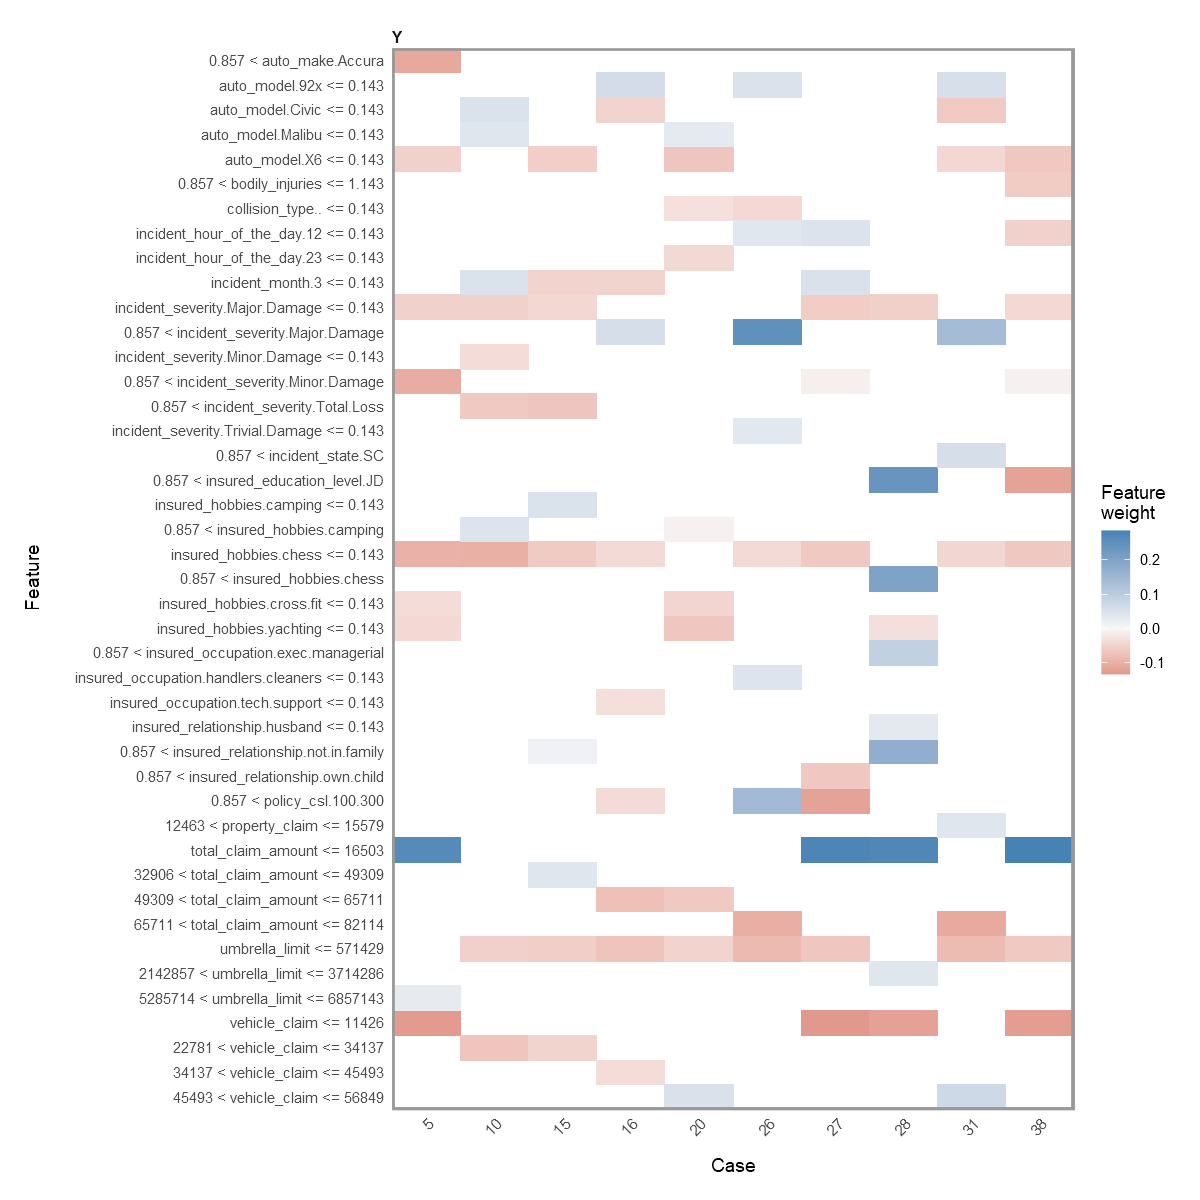

In [178]:
options(repr.plot.width=10, repr.plot.height=10)
plot_explanations(explanation_lrm)

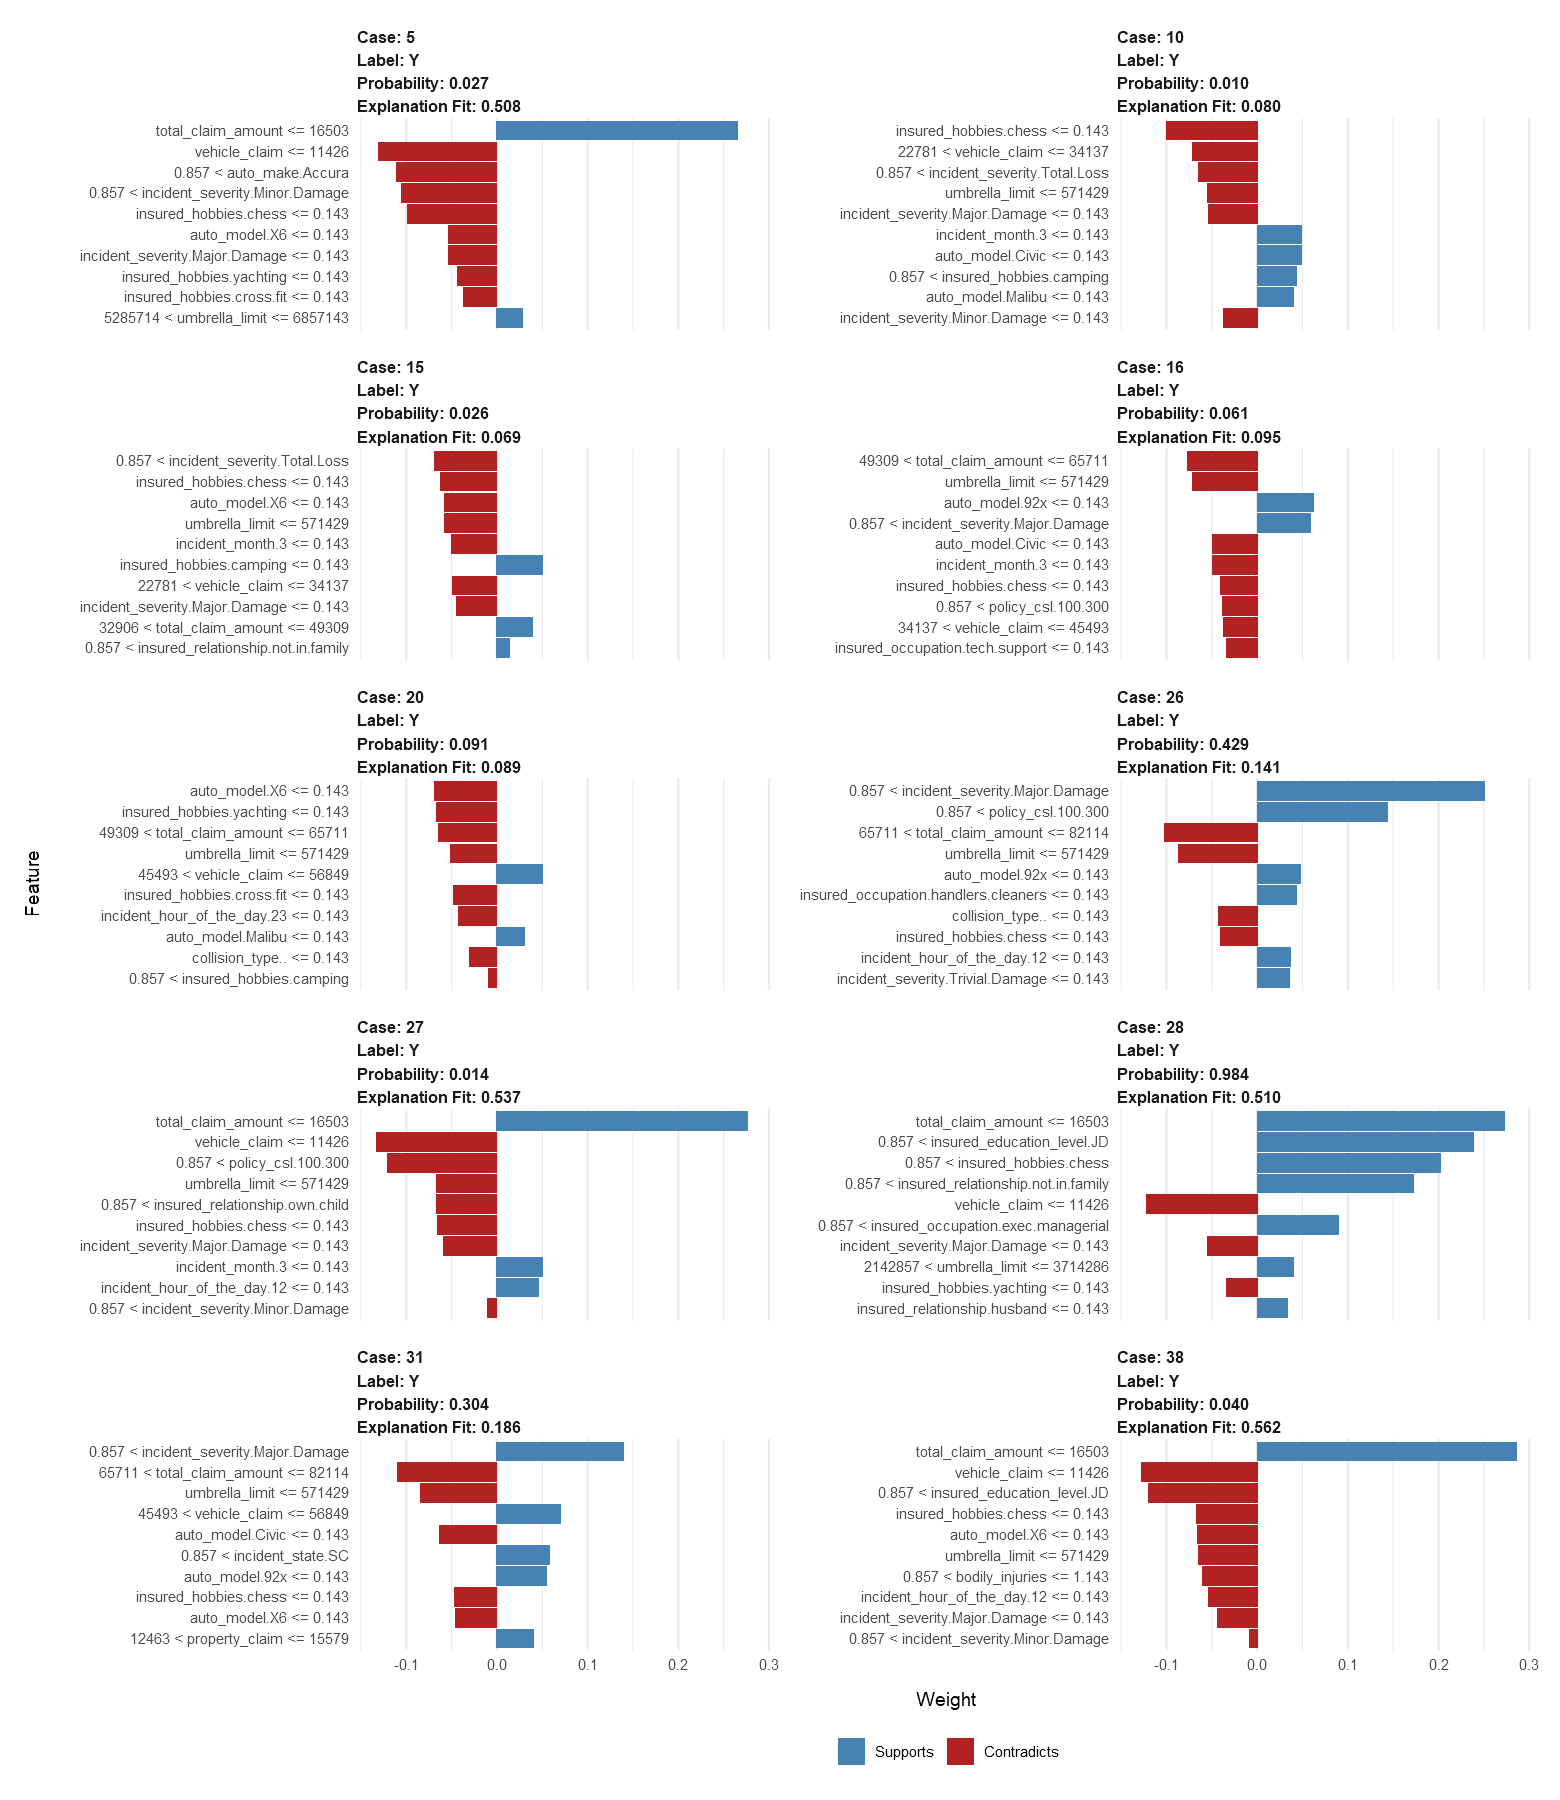

In [179]:
options(repr.plot.width = 13, repr.plot.height = 15) # set plot size in jupyter notebook
plot_features(explanation_lrm)

In [173]:
print("Labels in test data:")
df_test[1:10,"fraud_reported"]
print("Labels predicted by the logistic regression model:")
logreg_pred[1:10]

[1] "Labels in test data:"


[1] N N Y Y N Y N Y N N
Levels: N Y

[1] "Labels predicted by the logistic regression model:"


[1] N N N N N N N Y N N
Levels: N Y

It is immediately obvious that the explanations for the logistic regression model's decisions are much more diverse. In particular, the absolute values of the feature weights are higher and there are less extreme weights. But what we can also observe is that for the first ten test cases the LRM's performance is worse than the GBM's. Only one of the four fraud cases is detected (case 28). But before we compare the results of the two explainers, we first briefly have a look at the LRM and the LRM's explainer. The LRM is interpretable quite well (at least when regarding the signs of the features and their ordering), but it is a global model so it is unlikely that the global coefficients are similar to the explainer's feature weights.<br><br>
Note that a direct comparison of the feature weights and the coefficients is not meaningful. The coefficients are on a log odds scale and, as mentioned above, the coefficients for dummy and for numeric variables have a different meaning.

In [162]:
# All coefficient values of the LRM ordered according to their absolute value
coeffs <- as.data.frame(logreg_fit$finalModel$coefficients[order(abs(logreg_fit$finalModel$coefficients),decreasing = TRUE)])
colnames(coeffs) <- c("coefficient")
coeffs

coefficient  
insured_hobbies.chess                 5.099663e+00
(Intercept)                          -4.104132e+00
incident_severity.Major.Damage        3.960339e+00
insured_hobbies.cross.fit             3.204302e+00
auto_model.X6                         1.845817e+00
insured_hobbies.camping              -1.306642e+00
incident_hour_of_the_day.12          -1.286055e+00
incident_hour_of_the_day.13          -1.249836e+00
insured_hobbies.yachting              1.248707e+00
auto_model.Malibu                    -1.193814e+00
auto_model.92x                       -1.102362e+00
auto_model.Civic                      1.078985e+00
auto_make.Accura                     -9.984915e-01
insured_occupation.craft.repair       8.706534e-01
insured_occupation.exec.managerial    7.934624e-01
insured_relationship.husband         -7.740693e-01
collision_type.Rear.Collision         6.569793e-01
incident_severity.Total.Loss          6.349450e-01
incident_hour_of_the_day.23           6.334768e-01
insured_hobbies.golf                 -6.037513e-01
incident_severity.Minor.Damage        6.024819e-01
insured_occupation.handlers.cleaners -5.918008e-01
incident_month.3                     -5.821818e-01
insured_relationship.own.child       -5.485299e-01
collision_type..                      4.008462e-01
insured_relationship.not.in.family    3.465993e-01
insured_education_level.JD            3.446341e-01
insured_occupation.tech.support       2.761626e-01
auto_make.Ford                       -2.482421e-01
insured_education_level.High.School  -2.380212e-01
bodily_injuries                       1.923120e-01
incident_state.SC                     1.884482e-01
insured_sex.MALE                      9.996661e-02
insured_occupation.machine.op.inspct -9.627541e-02
policy_csl.100.300                   -9.476707e-02
vehicle_claim                         6.017249e-05
total_claim_amount                   -4.410368e-05
property_claim                        2.776051e-05
capital.gains                        -4.660742e-06
umbrella_limit                        1.171727e-07
incident_severity.Trivial.Damage                NA

Although the features have different weights for the different cases regarding the explainer, we can observe a lot of consistencies between the explainers and the LRM. Here are some examples:
 - case 5: auto_make.Accura (negative weight and negative coefficient)
 - case 5: total_claim_amount (LRM: negative, i.e., the higher the total_claim_amount, the less likely is fraud; in the explainer it is low and has a positive weight)
 - case 16: total_claim_amount (high value leading to a negative weight in the explainer)
 - case 16: incident_severity.Major.Damage (positive weight and positive coefficient)
 - case 26: incident_severity.Major.Damage (positive weight and positive coefficient)
 - case 28: insured_hobbies.chess (positive weight and positive coefficient)

### 5.3 Comparison of the GBM and the LRM explainers

Case 5 is assessed correctly by both models to be non fraudulent. Case 16 is assessed correctly by the GBM to be fraudulent whereas the LRM assesses non-fraud. Case 28 is a case where both the GBM and the LRM assess a (true) fraud suspicion.

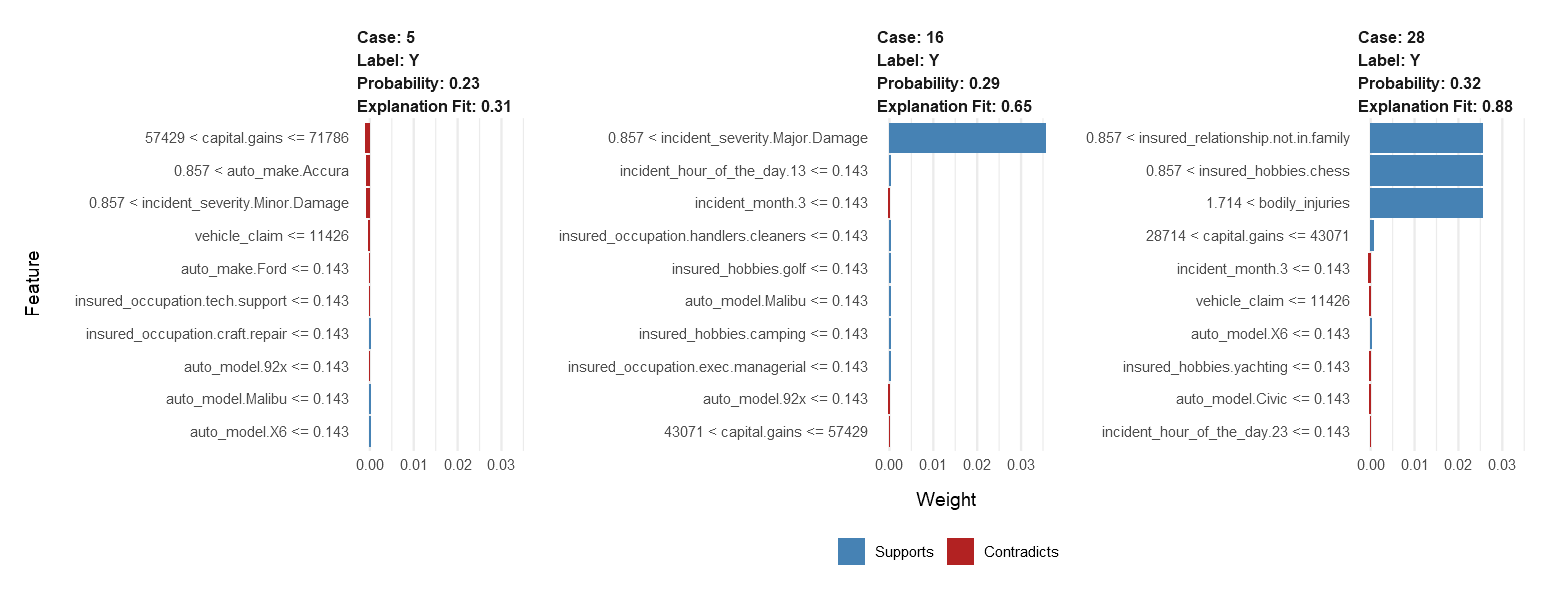

In [163]:
# The feature weights of the GBM explainer
options(repr.plot.width = 13, repr.plot.height = 5) # set plot size in jupyter notebook
plot_features(explanation,ncol=3,cases=c(5,16,28))

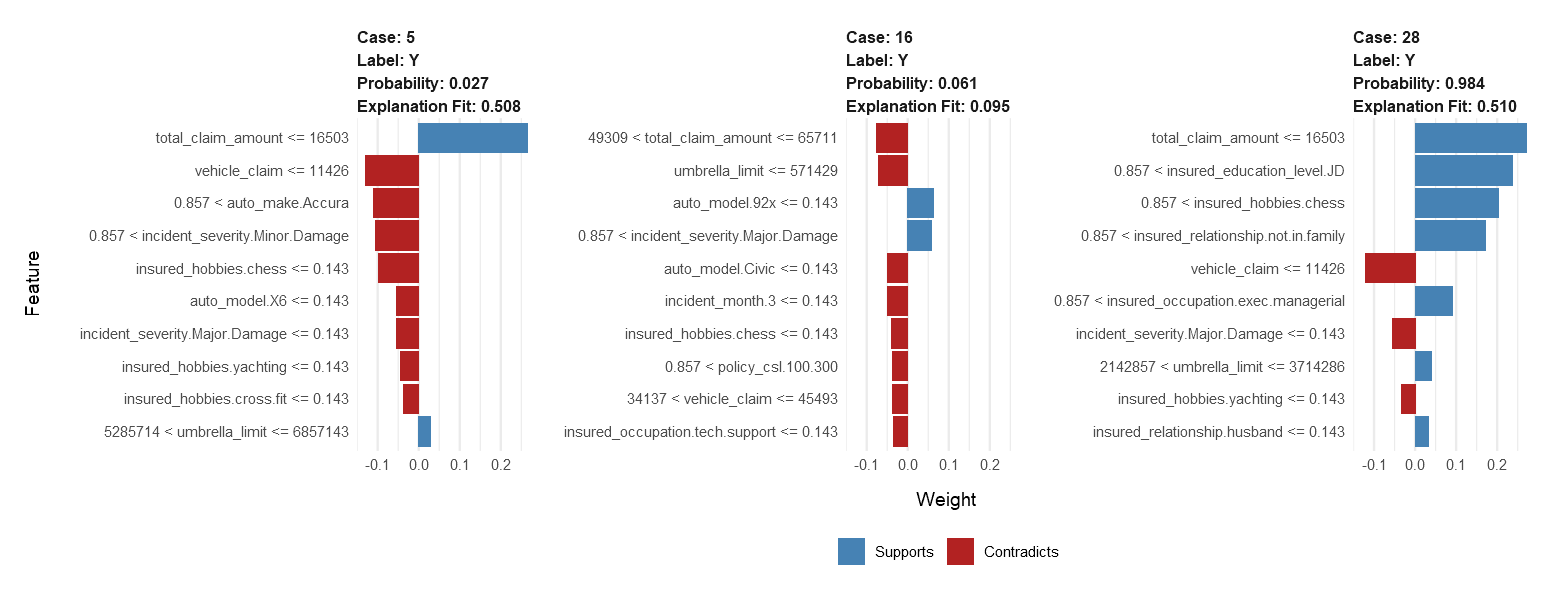

In [164]:
# The feature weights of the LRM explainer
options(repr.plot.width = 13, repr.plot.height = 5) # reset plot size in jupyter notebook
plot_features(explanation_lrm,ncol=3,cases=c(28,5,16))

 - case 5: The highest feature weight in the LRM explainer has a positive weight (total_claim_amount<=16503) supporting a fraud suspicion. This is no good explanation for non-fraud. Then again, the top 3 features for non-fraud are the same as features 2,3,4 in the GBM explainer. The feature seen as most important in the GBM (a certain bin of capital.gains) is not present in the LRM explanation. All other explanations (except the umbrella_limit in the LRM explanation) are not meaningful as they indicate the absence of nominal features where the factor variable has a lot of features.
 - case 16: The only meaningful explanation of the GBM explainer for fraud is the incident_severity.Major.Damage. All other features given in the explanation indicate the absence of nominal features (except the last one concerning capital.gains). Just one feature supporting a fraud suspicion may be no convincing explanation for the fraud analyst but it gives, of course, a hint that the analyst has a closer look on the case. The LRM explainer's explanation for non-fraud is a comparably high total_claim_amount (and vehicle_claim) and a low umbrella_limit as well as a certain policy_csl (100.300). The incident_severity.Major.Damage supporting a fraud suspicion is not enough for the LRM to decide for fraud (although we know that this decision is wrong).
 - case 28: There are three main reasons given by the GBM explainer supporting fraud, the insured_relationship.not.in.family, the insured_hobbies.chess and more than 1.7 bodily_injuries. Also the capital.gains bin slightly supports a fraud suspicion. Only the very low vehicle_claim contradicts fraud. The LRM also assesses a fraud suspicion for this case, but the LRM explainer's explanations do not fully overlap with those of the GBM explainer's. The insured_hobbies.chess and the insured_relationship.not.in.family are the same, but it also states that the low total_claim_amount as well as the insured_education_level.JD, the insured_occupation.exec.managerial and a high umbrella_limit support a fraud suspicion. The absence of insured_relationship.husband is (more or less) the opposite of being not in family. Also the low vehicle_claim is the only feature contradicting a fraud suspicion.

## 6. Conclusion

With the above explanations it could be possible to provide a pro and con list for the fraud analyst to help him come to a decision (fraud or non-fraud suspicion) by suggesting relevant features that could drive the decision. As the explanations strongly depend on the model to be explained and also on the construction of the explainer (definition of neighborhood, set of models suitable to be explainers, etc.) it could be helpful to have several models trying to assess whether the claim is fraudulent or not. But keep in mind that the explanations obtained through LIME try to explain the decisions of a certain model and that it, of course, also tries to find explanations for wrong decisions (LIME does not know about true or false decisions but it only knows the output of the model to be explained). Further, how dummyfied variables are handled in the above approach is not optimal. Some more work should be done to better exploit this information.
It is common to use ensembles of models for predictions, so it could also be helpful to use an ensemble of explaining techniques to become independent of certain configurations and to achieve interpretable machine learning when a priori non explainable prediction methods have to be used.